In [5]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
!pip install -q keras numpy sklearn h5py matplotlib

In [0]:
# Import all relevant libraries
import warnings
def fxn(): 
	warnings.warn("deprecated",DeprecationWarning)

with warnings.catch_warnings( ):
    warnings.simplefilter("ignore")
    fxn( )

# Keras imports
import keras
from keras.models import Sequential
from keras.layers import Permute, Flatten, Softmax, Dense, Conv1D, Conv2D, Conv2DTranspose, AveragePooling2D, Activation, Reshape, Dropout, BatchNormalization, MaxPooling2D, LSTM, GRU

# Other
import numpy as np
import h5py
import sklearn
from sklearn.model_selection import StratifiedKFold, train_test_split, StratifiedShuffleSplit
from sklearn import preprocessing
import matplotlib.pyplot as plt

# random seed for reproducability
np.random.seed(1)

In [0]:
# Load data from specific trial
def get_trial(trial_num):    
    trial = h5py.File('drive/ECE239/data/A0' + str(trial_num) + 'T_slice.mat', 'r')
    X = np.copy(trial['image'])
    y = np.copy(trial['type'])
    y = y[0,0:X.shape[0]:1]
    y = np.asarray(y, dtype=np.int32)
    y -= 769                            # shift class labels to [0-3]
    X = np.nan_to_num(X)[:, :22, :]     # remove EOG channels
    return X, y

def get_all_trials():
    X_total = np.concatenate([get_trial(trial_num)[0] for trial_num in range(1, 9)], axis=0)
    y_total = np.concatenate([get_trial(trial_num)[1] for trial_num in range(1, 9)], axis=0)
    return X_total, y_total

def stratified_train_test_split(X, y, k, num_trials):
    ''' Returns a stratified train/test split, for k number of splits.
    Return value is in the form [(train indices, test indices), ... for k folds ]
    '''
    sss = StratifiedShuffleSplit(n_splits=k, test_size=50*num_trials)
    return sss.split(X, y)

In [17]:
num_folds = 5

# Get the data from one person
# X, y = get_trial(2)
# num_trials = 1

# Get the data from all the people
X, y = get_all_trials()
num_trials = 9

# 0 mean and unit variance
temp = np.reshape(X, (X.shape[0], -1))
X = np.reshape(preprocessing.scale(temp), X.shape)

# Generate train/test split
y_cat = keras.utils.to_categorical(y, num_classes=4)
tt_splits = stratified_train_test_split(X, y, num_folds, num_trials)

print(tt_splits)

# The data for each trial is of the shape (288, 22, 1000)
#   There are 288 samples per trial (12 of each class per "run", 4 classes, 6 "runs" 
#                                   at different time periods of the day)
#   There are 22 electrodes from the EEG (represents spatial aspect of the signals)
#   There are 1000 time units (4 seconds of data, sampled at 250Hz). The first 250 units
#                                   are when no movement occurs (but the cue is heard) and
#                                   the next 750 units are when the movement occurs
# The labels for each trial belong in one of 4 classes
#   0 - left
#   1 - right
#   2 - foot
#   3 - tongue

# Set training params for NN
batch_size = 32
val_split = 0.2
num_epochs = 5

<generator object BaseShuffleSplit.split at 0x7fafc3a8fc50>


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_3 (Permute)          (None, 1000, 22)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 1000, 128)         77312     
_________________________________________________________________
flatten_3 (Flatten)          (None, 128000)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 200)               25600200  
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 804       
Total params: 25,678,316
Trainable params: 25,678,316
Non-trainable params: 0
________________________________________________________________

1483/1483 [==============================] - 79s 53ms/step - loss: 1.0428 - acc: 0.5738 - val_loss: 1.2403 - val_acc: 0.4420
Epoch 3/5
1483/1483 [==============================] - 79s 53ms/step - loss: 0.8374 - acc: 0.7073 - val_loss: 1.2226 - val_acc: 0.4582
Epoch 4/5
1483/1483 [==============================] - 79s 53ms/step - loss: 0.6854 - acc: 0.7862 - val_loss: 1.2477 - val_acc: 0.4528
Epoch 5/5
1483/1483 [==============================] - 79s 53ms/step - loss: 0.5632 - acc: 0.8469 - val_loss: 1.2445 - val_acc: 0.4717


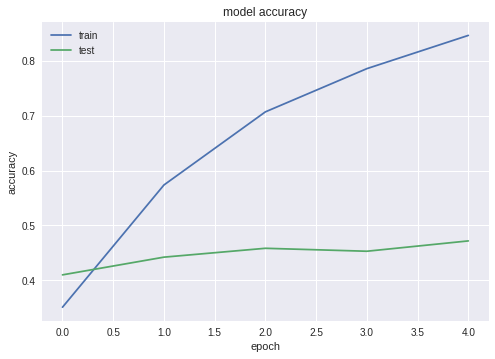

450/450 [==============================] - 6s 13ms/step
[1.2548088306850858, 0.46]
0.092


In [18]:
# Create LSTM model

# Simple LSTM model with 1 LSTM layer and some dense layers
# LSTM layer accepts data in the form (samples, timesteps, features)

def make_LSTM():
    # input is of the form: (sample, spatial, temporal)
    model = Sequential()
    model.add(Permute((2, 1), input_shape=(22, 1000)))
    
    # LSTM layers
    model.add(LSTM(128, dropout=0.0, recurrent_dropout=0.0, return_sequences=True))
    
    # Dense layers
    model.add(Flatten())
    model.add(Dense(units=200, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(units=4, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='SGD',
                  metrics=['accuracy'])
    
    print(model.summary())
    
    return model

avg_acc = 0
for train_idx, test_idx in tt_splits:
    X_train = X[train_idx]
    y_train = y_cat[train_idx]
    X_test = X[test_idx]
    y_test = y_cat[test_idx]
    
    model = make_LSTM()
    
    history = model.fit(X_train, y_train, validation_split=val_split, epochs=num_epochs, batch_size=batch_size)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    metrics = model.evaluate(X_test, y_test, batch_size=batch_size)
    avg_acc += metrics[1]
    print(metrics)
    break
    
print(avg_acc)

This previous example overfit pretty badly, so we'll try removing the dense layers.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_4 (Permute)          (None, 1000, 22)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 1000, 128)         77312     
_________________________________________________________________
flatten_4 (Flatten)          (None, 128000)            0         
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 512004    
Total params: 589,316
Trainable params: 589,316
Non-trainable params: 0
_________________________________________________________________
None
Train on 1483 samples, validate on 371 samples
Epoch 1/5
1483/1483 [==============================] - 78s 53ms/step - loss: 1.3478 - acc: 0.3661 - val_loss: 1.3526 - val_acc: 0.3989
Epoch 2/5
1376/1483 [==========================>...] - ETA: 5s - loss: 1.0389 - a

1483/1483 [==============================] - 76s 51ms/step - loss: 1.0336 - acc: 0.5853 - val_loss: 1.3386 - val_acc: 0.4178
Epoch 3/5
1483/1483 [==============================] - 77s 52ms/step - loss: 0.8494 - acc: 0.6736 - val_loss: 1.3078 - val_acc: 0.4420
Epoch 4/5
1483/1483 [==============================] - 77s 52ms/step - loss: 0.7283 - acc: 0.7552 - val_loss: 1.3116 - val_acc: 0.4367
Epoch 5/5
1483/1483 [==============================] - 76s 51ms/step - loss: 0.6324 - acc: 0.8051 - val_loss: 1.3218 - val_acc: 0.4447


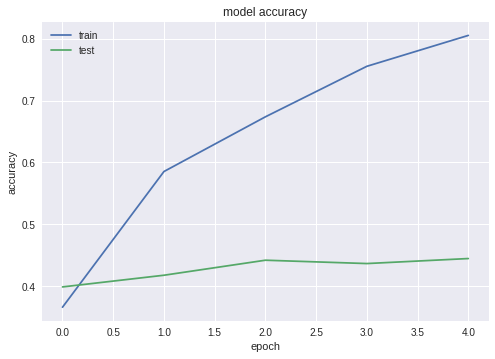

450/450 [==============================] - 6s 13ms/step
[1.1940823831823137, 0.49777777777777776]
0.09955555555555555


In [19]:
# Create LSTM model

# Simple LSTM model with 1 LSTM layer and no dense layers
# LSTM layer accepts data in the form (samples, timesteps, features)

num_epochs = 5

def make_LSTM():
    # input is of the form: (sample, spatial, temporal)
    model = Sequential()
    model.add(Permute((2, 1), input_shape=(22, 1000)))
    
    # LSTM layers
    model.add(LSTM(128, dropout=0.0, recurrent_dropout=0.0, return_sequences=True))
    
    # Dense layers
    model.add(Flatten())
    model.add(Dense(units=4, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='SGD',
                  metrics=['accuracy'])
    
    print(model.summary())
    
    return model

avg_acc = 0
for train_idx, test_idx in tt_splits:
    X_train = X[train_idx]
    y_train = y_cat[train_idx]
    X_test = X[test_idx]
    y_test = y_cat[test_idx]
    
    model = make_LSTM()
    
    history = model.fit(X_train, y_train, validation_split=val_split, epochs=num_epochs, batch_size=batch_size)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    metrics = model.evaluate(X_test, y_test, batch_size=batch_size)
    avg_acc += metrics[1]
    print(metrics)
    break

print(avg_acc)

The result was similar, but trained much quicker

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_8 (Permute)          (None, 1000, 22)          0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 1000, 128)         77312     
_________________________________________________________________
flatten_8 (Flatten)          (None, 128000)            0         
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 512004    
Total params: 589,316
Trainable params: 589,316
Non-trainable params: 0
_________________________________________________________________
None
Train on 1483 samples, validate on 371 samples
Epoch 1/5
1483/1483 [==============================] - 84s 57ms/step - loss: 1.3656 - acc: 0.3358 - val_loss: 1.3115 - val_acc: 0.3962
Epoch 2/5
1376/1483 [==========================>...] - ETA: 5s - loss: 1.0949 - a

1483/1483 [==============================] - 82s 55ms/step - loss: 1.0987 - acc: 0.5442 - val_loss: 1.2853 - val_acc: 0.3935
Epoch 3/5
1483/1483 [==============================] - 83s 56ms/step - loss: 0.9432 - acc: 0.6264 - val_loss: 1.2293 - val_acc: 0.4151
Epoch 4/5
1483/1483 [==============================] - 83s 56ms/step - loss: 0.8665 - acc: 0.6642 - val_loss: 1.2476 - val_acc: 0.4232
Epoch 5/5
1483/1483 [==============================] - 82s 56ms/step - loss: 0.7883 - acc: 0.7161 - val_loss: 1.2629 - val_acc: 0.4232


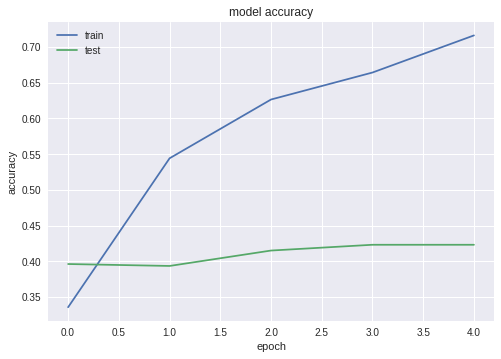

450/450 [==============================] - 6s 14ms/step
[1.2352894277042812, 0.4711111111111111]
0.4711111111111111


In [27]:
# Create LSTM model

# Simple LSTM model with stacked LSTM layers (inspiration from NLP) - 3 layers
# LSTM layer accepts data in the form (samples, timesteps, features)

num_epochs = 5

def make_LSTM():
    # input is of the form: (sample, spatial, temporal)
    model = Sequential()
    model.add(Permute((2, 1), input_shape=(22, 1000)))
    
    # LSTM layers
    model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.0, return_sequences=True))
    
    # Dense layers
    model.add(Flatten())
    model.add(Dense(units=4, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='SGD',
                  metrics=['accuracy'])
    
    print(model.summary())
    
    return model

avg_acc = 0
for train_idx, test_idx in tt_splits:
    X_train = X[train_idx]
    y_train = y_cat[train_idx]
    X_test = X[test_idx]
    y_test = y_cat[test_idx]
    
    model = make_LSTM()
    
    history = model.fit(X_train, y_train, validation_split=val_split, epochs=num_epochs, batch_size=batch_size)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    metrics = model.evaluate(X_test, y_test, batch_size=batch_size)
    avg_acc += metrics[1]
    print(metrics)
    break

print(avg_acc)

Training is very slow, and dropout doesn't help that much.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_10 (Permute)         (None, 1000, 22)          0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 1000, 32)          7040      
_________________________________________________________________
lstm_19 (LSTM)               (None, 1000, 32)          8320      
_________________________________________________________________
lstm_20 (LSTM)               (None, 1000, 32)          8320      
_________________________________________________________________
flatten_10 (Flatten)         (None, 32000)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 4)                 128004    
Total params: 151,684
Trainable params: 151,684
Non-trainable params: 0
_________________________________________________________________
None

1483/1483 [==============================] - 244s 165ms/step - loss: 1.3190 - acc: 0.4113 - val_loss: 1.3245 - val_acc: 0.3747
Epoch 3/5
1483/1483 [==============================] - 242s 163ms/step - loss: 1.2711 - acc: 0.4417 - val_loss: 1.3057 - val_acc: 0.3720
Epoch 4/5
1483/1483 [==============================] - 240s 162ms/step - loss: 1.2319 - acc: 0.4673 - val_loss: 1.2981 - val_acc: 0.3693
Epoch 5/5
1483/1483 [==============================] - 241s 163ms/step - loss: 1.1979 - acc: 0.4916 - val_loss: 1.2854 - val_acc: 0.3666


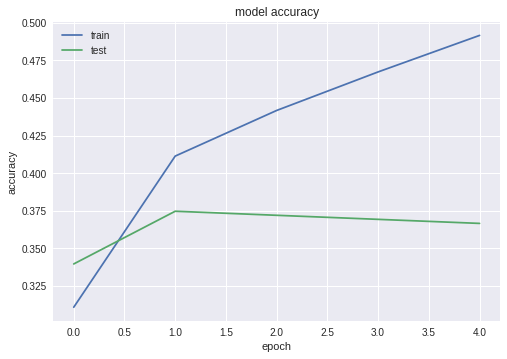

450/450 [==============================] - 15s 33ms/step
[1.2781465938356187, 0.39555555555555555]
0.39555555555555555


In [29]:
# Create LSTM model

# Simple LSTM model with stacked LSTM layers (inspiration from NLP) - many layers, with dropout
# LSTM layer accepts data in the form (samples, timesteps, features)

num_epochs = 5

def make_LSTM():
    # input is of the form: (sample, spatial, temporal)
    model = Sequential()
    model.add(Permute((2, 1), input_shape=(22, 1000)))
    
    # LSTM layers
    model.add(LSTM(32, return_sequences=True))
    model.add(LSTM(32, return_sequences=True))
    model.add(LSTM(32, return_sequences=True))
    
    # Dense layers
    model.add(Flatten())
    model.add(Dense(units=4, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='SGD',
                  metrics=['accuracy'])
    
    print(model.summary())
    
    return model

avg_acc = 0
for train_idx, test_idx in tt_splits:
    X_train = X[train_idx]
    y_train = y_cat[train_idx]
    X_test = X[test_idx]
    y_test = y_cat[test_idx]
    
    model = make_LSTM()
    
    history = model.fit(X_train, y_train, validation_split=val_split, epochs=num_epochs, batch_size=batch_size)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    metrics = model.evaluate(X_test, y_test, batch_size=batch_size)
    avg_acc += metrics[1]
    print(metrics)
    break

print(avg_acc)

Training is even slower, and improvement is not that much.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_11 (Permute)         (None, 1000, 22)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 1000, 32)          5280      
_________________________________________________________________
gru_2 (GRU)                  (None, 1000, 32)          6240      
_________________________________________________________________
flatten_11 (Flatten)         (None, 32000)             0         
_________________________________________________________________
dense_14 (Dense)             (None, 4)                 128004    
Total params: 139,524
Trainable params: 139,524
Non-trainable params: 0
_________________________________________________________________
None
Train on 1483 samples, validate on 371 samples
Epoch 1/5
1483/1483 [==============================] - 131s 89ms/step - loss: 1.3592

1483/1483 [==============================] - 129s 87ms/step - loss: 1.0816 - acc: 0.5496 - val_loss: 1.2580 - val_acc: 0.4447
Epoch 3/5
1483/1483 [==============================] - 131s 88ms/step - loss: 0.9374 - acc: 0.6365 - val_loss: 1.2569 - val_acc: 0.4420
Epoch 4/5
1483/1483 [==============================] - 131s 88ms/step - loss: 0.8366 - acc: 0.6885 - val_loss: 1.2596 - val_acc: 0.4420
Epoch 5/5
1483/1483 [==============================] - 131s 88ms/step - loss: 0.7475 - acc: 0.7390 - val_loss: 1.2595 - val_acc: 0.4771


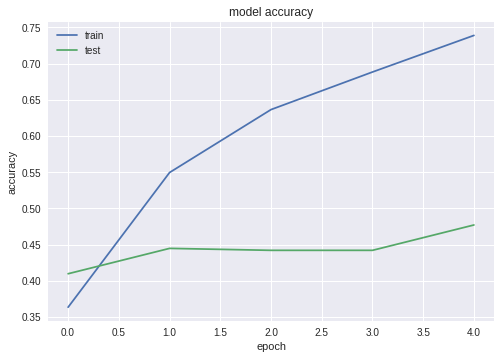

450/450 [==============================] - 8s 17ms/step
[1.1975412130355836, 0.4888888888888889]
0.4888888888888889


In [32]:
# Create GRU model

# GRU uses less params than LSTM, for faster training
# Simple GRU model with stacked GRU layers (inspiration from NLP) - 3 layers, with dropout
# GRU layer accepts data in the form (samples, timesteps, features)

def make_GRU():
    # input is of the form: (sample, spatial, temporal)
    model = Sequential()
    model.add(Permute((2, 1), input_shape=(22, 1000)))
    
    # GRU layers
    model.add(GRU(32, return_sequences=True))
    model.add(GRU(32, return_sequences=True))
    
    # Dense layers
    model.add(Flatten())
    model.add(Dense(units=4, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='SGD',
                  metrics=['accuracy'])
    
    print(model.summary())
    
    return model

avg_acc = 0
for train_idx, test_idx in tt_splits:
    X_train = X[train_idx]
    y_train = y_cat[train_idx]
    X_test = X[test_idx]
    y_test = y_cat[test_idx]
    
    model = make_GRU()
    
    history = model.fit(X_train, y_train, validation_split=val_split, epochs=num_epochs, batch_size=batch_size)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    metrics = model.evaluate(X_test, y_test, batch_size=batch_size)
    avg_acc += metrics[1]
    print(metrics)
    break

print(avg_acc)

GRU is a little bit faster, still similar accuracy

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_25 (Permute)         (None, 1000, 22)          0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 991, 25)           5525      
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 982, 25)           6275      
_________________________________________________________________
permute_26 (Permute)         (None, 25, 982)           0         
_________________________________________________________________
gru_27 (GRU)                 (None, 25, 32)            97440     
_________________________________________________________________
gru_28 (GRU)                 (None, 25, 32)            6240      
_________________________________________________________________
flatten_24 (Flatten)         (None, 800)               0         
__________

1483/1483 [==============================] - 4s 3ms/step - loss: 1.3724 - acc: 0.3061 - val_loss: 1.3960 - val_acc: 0.2480
Epoch 3/30
1483/1483 [==============================] - 4s 3ms/step - loss: 1.3473 - acc: 0.3540 - val_loss: 1.3906 - val_acc: 0.2749
Epoch 4/30
1483/1483 [==============================] - 4s 3ms/step - loss: 1.3204 - acc: 0.3877 - val_loss: 1.3866 - val_acc: 0.2749
Epoch 5/30
1483/1483 [==============================] - 4s 3ms/step - loss: 1.2889 - acc: 0.4363 - val_loss: 1.3805 - val_acc: 0.2965
Epoch 6/30
1483/1483 [==============================] - 4s 3ms/step - loss: 1.2531 - acc: 0.4754 - val_loss: 1.3714 - val_acc: 0.3046
Epoch 7/30
 800/1483 [===============>..............] - ETA: 1s - loss: 1.2181 - acc: 0.5000

1483/1483 [==============================] - 4s 3ms/step - loss: 1.2116 - acc: 0.5111 - val_loss: 1.3588 - val_acc: 0.3208
Epoch 8/30
1483/1483 [==============================] - 4s 3ms/step - loss: 1.1652 - acc: 0.5239 - val_loss: 1.3450 - val_acc: 0.3423
Epoch 9/30
1483/1483 [==============================] - 4s 3ms/step - loss: 1.1129 - acc: 0.5563 - val_loss: 1.3370 - val_acc: 0.3504
Epoch 10/30
1483/1483 [==============================] - 4s 3ms/step - loss: 1.0569 - acc: 0.5927 - val_loss: 1.3370 - val_acc: 0.3342
Epoch 11/30
1483/1483 [==============================] - 4s 3ms/step - loss: 0.9958 - acc: 0.6305 - val_loss: 1.3177 - val_acc: 0.3720
Epoch 12/30
 800/1483 [===============>..............] - ETA: 1s - loss: 0.9370 - acc: 0.6737

1483/1483 [==============================] - 4s 3ms/step - loss: 0.9325 - acc: 0.6696 - val_loss: 1.3231 - val_acc: 0.3666
Epoch 13/30
1483/1483 [==============================] - 4s 3ms/step - loss: 0.8676 - acc: 0.6898 - val_loss: 1.3318 - val_acc: 0.3720
Epoch 14/30
1483/1483 [==============================] - 4s 3ms/step - loss: 0.7987 - acc: 0.7235 - val_loss: 1.3327 - val_acc: 0.3720
Epoch 15/30
1483/1483 [==============================] - 4s 3ms/step - loss: 0.7257 - acc: 0.7640 - val_loss: 1.3417 - val_acc: 0.3962
Epoch 16/30
1483/1483 [==============================] - 4s 3ms/step - loss: 0.6513 - acc: 0.8092 - val_loss: 1.3875 - val_acc: 0.3935
Epoch 17/30
 800/1483 [===============>..............] - ETA: 1s - loss: 0.5714 - acc: 0.8387

1483/1483 [==============================] - 4s 3ms/step - loss: 0.5761 - acc: 0.8382 - val_loss: 1.4257 - val_acc: 0.3962
Epoch 18/30
1483/1483 [==============================] - 4s 3ms/step - loss: 0.5000 - acc: 0.8820 - val_loss: 1.4914 - val_acc: 0.4043
Epoch 19/30
1483/1483 [==============================] - 4s 3ms/step - loss: 0.4258 - acc: 0.9144 - val_loss: 1.5024 - val_acc: 0.3989
Epoch 20/30
1483/1483 [==============================] - 4s 3ms/step - loss: 0.3559 - acc: 0.9393 - val_loss: 1.5647 - val_acc: 0.4016
Epoch 21/30
1483/1483 [==============================] - 4s 3ms/step - loss: 0.2922 - acc: 0.9649 - val_loss: 1.6035 - val_acc: 0.3989
Epoch 22/30
 800/1483 [===============>..............] - ETA: 1s - loss: 0.2367 - acc: 0.9800

1483/1483 [==============================] - 4s 3ms/step - loss: 0.2367 - acc: 0.9804 - val_loss: 1.6990 - val_acc: 0.4016
Epoch 23/30
1483/1483 [==============================] - 4s 3ms/step - loss: 0.1914 - acc: 0.9885 - val_loss: 1.7020 - val_acc: 0.3935
Epoch 24/30
1483/1483 [==============================] - 4s 3ms/step - loss: 0.1513 - acc: 0.9953 - val_loss: 1.7785 - val_acc: 0.3774
Epoch 25/30
1483/1483 [==============================] - 4s 3ms/step - loss: 0.1208 - acc: 0.9987 - val_loss: 1.8157 - val_acc: 0.3747
Epoch 26/30
1483/1483 [==============================] - 4s 3ms/step - loss: 0.0980 - acc: 1.0000 - val_loss: 1.8854 - val_acc: 0.3585
Epoch 27/30
 800/1483 [===============>..............] - ETA: 1s - loss: 0.0786 - acc: 1.0000

1483/1483 [==============================] - 4s 3ms/step - loss: 0.0803 - acc: 1.0000 - val_loss: 1.9306 - val_acc: 0.3666
Epoch 28/30
1483/1483 [==============================] - 4s 3ms/step - loss: 0.0673 - acc: 1.0000 - val_loss: 1.9786 - val_acc: 0.3666
Epoch 29/30
1483/1483 [==============================] - 4s 3ms/step - loss: 0.0569 - acc: 1.0000 - val_loss: 2.0311 - val_acc: 0.3693
Epoch 30/30
1483/1483 [==============================] - 4s 3ms/step - loss: 0.0489 - acc: 1.0000 - val_loss: 2.0527 - val_acc: 0.3666


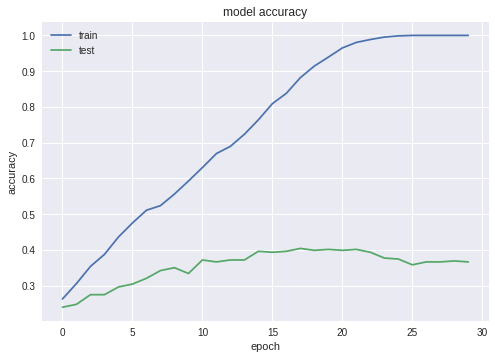

450/450 [==============================] - 0s 891us/step
[2.3261600787109797, 0.3688888888888889]
0.3688888888888889


In [45]:
num_epochs = 30

# Create GRU model

# GRU uses less params than LSTM, for faster training
# Simple GRU model with stacked GRU layers (inspiration from NLP) - 3 layers, with dropout
# GRU layer accepts data in the form (samples, timesteps, features)

def make_GRU():
    # input is of the form: (sample, spatial, temporal)
    model = Sequential()
    model.add(Permute((2, 1), input_shape=(22, 1000)))
    
    model.add(Conv1D(filters = 25, kernel_size = 10, activation = 'elu'))
    model.add(Conv1D(filters = 25, kernel_size = 10, activation = 'elu'))
    
    model.add(Permute((2, 1)))
    
    # GRU layers
    model.add(GRU(32, return_sequences=True))
    model.add(GRU(32, return_sequences=True))
    
    # Dense layers
    model.add(Flatten())
    model.add(Dense(units=4, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='SGD',
                  metrics=['accuracy'])
    
    print(model.summary())
    
    return model

# make_GRU()
  
avg_acc = 0
for train_idx, test_idx in tt_splits:
    X_train = X[train_idx]
    y_train = y_cat[train_idx]
    X_test = X[test_idx]
    y_test = y_cat[test_idx]
    
    model = make_GRU()
    
    history = model.fit(X_train, y_train, validation_split=val_split, epochs=num_epochs, batch_size=batch_size)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    metrics = model.evaluate(X_test, y_test, batch_size=batch_size)
    avg_acc += metrics[1]
    print(metrics)
    break

print(avg_acc)

Model trained much faster than previous ones, but still overfit, so we can try some regularization techniques.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_47 (Permute)         (None, 1000, 22)          0         
_________________________________________________________________
conv1d_39 (Conv1D)           (None, 976, 64)           35264     
_________________________________________________________________
dropout_22 (Dropout)         (None, 976, 64)           0         
_________________________________________________________________
conv1d_40 (Conv1D)           (None, 952, 64)           102464    
_________________________________________________________________
dropout_23 (Dropout)         (None, 952, 64)           0         
_________________________________________________________________
permute_48 (Permute)         (None, 64, 952)           0         
_________________________________________________________________
gru_55 (GRU)                 (None, 64, 128)           415104    
__________

1483/1483 [==============================] - 19s 13ms/step - loss: 1.4341 - acc: 0.2475 - val_loss: 1.3754 - val_acc: 0.2830
Epoch 2/30
1483/1483 [==============================] - 15s 10ms/step - loss: 1.4030 - acc: 0.2744 - val_loss: 1.3682 - val_acc: 0.3208
Epoch 3/30
1483/1483 [==============================] - 15s 10ms/step - loss: 1.3763 - acc: 0.2987 - val_loss: 1.3486 - val_acc: 0.3208
Epoch 4/30
1483/1483 [==============================] - 15s 10ms/step - loss: 1.3586 - acc: 0.3277 - val_loss: 1.3163 - val_acc: 0.3558
Epoch 5/30
1483/1483 [==============================] - 15s 10ms/step - loss: 1.2983 - acc: 0.3985 - val_loss: 1.2839 - val_acc: 0.4097
Epoch 6/30
 704/1483 [=============>................] - ETA: 7s - loss: 1.2667 - acc: 0.4062

1483/1483 [==============================] - 15s 10ms/step - loss: 1.2630 - acc: 0.4127 - val_loss: 1.2473 - val_acc: 0.4178
Epoch 7/30
1483/1483 [==============================] - 15s 10ms/step - loss: 1.1927 - acc: 0.4801 - val_loss: 1.2088 - val_acc: 0.4636
Epoch 8/30
1483/1483 [==============================] - 15s 10ms/step - loss: 1.1201 - acc: 0.5273 - val_loss: 1.1624 - val_acc: 0.4798
Epoch 9/30
1483/1483 [==============================] - 15s 10ms/step - loss: 1.0745 - acc: 0.5415 - val_loss: 1.2962 - val_acc: 0.4636
Epoch 10/30
1483/1483 [==============================] - 15s 10ms/step - loss: 1.0205 - acc: 0.5934 - val_loss: 1.1342 - val_acc: 0.5148
Epoch 11/30
 672/1483 [============>.................] - ETA: 7s - loss: 0.9931 - acc: 0.5789

1483/1483 [==============================] - 15s 10ms/step - loss: 0.9909 - acc: 0.5745 - val_loss: 1.1308 - val_acc: 0.5418
Epoch 12/30
1483/1483 [==============================] - 15s 10ms/step - loss: 0.9257 - acc: 0.6231 - val_loss: 1.1781 - val_acc: 0.5148
Epoch 13/30
1483/1483 [==============================] - 15s 10ms/step - loss: 0.8985 - acc: 0.6365 - val_loss: 1.1819 - val_acc: 0.5229
Epoch 14/30
1483/1483 [==============================] - 15s 10ms/step - loss: 0.8509 - acc: 0.6548 - val_loss: 1.2429 - val_acc: 0.5229
Epoch 15/30
1483/1483 [==============================] - 15s 10ms/step - loss: 0.8280 - acc: 0.6575 - val_loss: 1.2215 - val_acc: 0.5364
Epoch 16/30
 640/1483 [===========>..................] - ETA: 7s - loss: 0.7655 - acc: 0.6969

1483/1483 [==============================] - 15s 10ms/step - loss: 0.7829 - acc: 0.6918 - val_loss: 1.3105 - val_acc: 0.5229
Epoch 17/30
1483/1483 [==============================] - 15s 10ms/step - loss: 0.7399 - acc: 0.6972 - val_loss: 1.3144 - val_acc: 0.4906
Epoch 18/30
1483/1483 [==============================] - 15s 10ms/step - loss: 0.7069 - acc: 0.7181 - val_loss: 1.2942 - val_acc: 0.5337
Epoch 19/30
1483/1483 [==============================] - 15s 10ms/step - loss: 0.6856 - acc: 0.7276 - val_loss: 1.3720 - val_acc: 0.5175
Epoch 20/30
1483/1483 [==============================] - 15s 10ms/step - loss: 0.6392 - acc: 0.7498 - val_loss: 1.4333 - val_acc: 0.5337
Epoch 21/30
 640/1483 [===========>..................] - ETA: 7s - loss: 0.6093 - acc: 0.7688

1483/1483 [==============================] - 15s 10ms/step - loss: 0.6119 - acc: 0.7606 - val_loss: 1.4853 - val_acc: 0.5148
Epoch 22/30
1483/1483 [==============================] - 15s 10ms/step - loss: 0.5920 - acc: 0.7653 - val_loss: 1.4782 - val_acc: 0.5067
Epoch 23/30
1483/1483 [==============================] - 15s 10ms/step - loss: 0.5517 - acc: 0.7889 - val_loss: 1.5779 - val_acc: 0.4852
Epoch 24/30
1483/1483 [==============================] - 15s 10ms/step - loss: 0.4790 - acc: 0.8200 - val_loss: 1.5416 - val_acc: 0.5067
Epoch 25/30
1483/1483 [==============================] - 14s 10ms/step - loss: 0.4624 - acc: 0.8254 - val_loss: 1.6017 - val_acc: 0.4906
Epoch 26/30
 640/1483 [===========>..................] - ETA: 7s - loss: 0.4427 - acc: 0.8234

1483/1483 [==============================] - 14s 10ms/step - loss: 0.4410 - acc: 0.8294 - val_loss: 1.7100 - val_acc: 0.5067
Epoch 27/30
1483/1483 [==============================] - 15s 10ms/step - loss: 0.4285 - acc: 0.8395 - val_loss: 1.7699 - val_acc: 0.5094
Epoch 28/30
1483/1483 [==============================] - 15s 10ms/step - loss: 0.3607 - acc: 0.8645 - val_loss: 1.7584 - val_acc: 0.5202
Epoch 29/30
1483/1483 [==============================] - 14s 10ms/step - loss: 0.3357 - acc: 0.8780 - val_loss: 1.9048 - val_acc: 0.5013
Epoch 30/30
1483/1483 [==============================] - 15s 10ms/step - loss: 0.3029 - acc: 0.8941 - val_loss: 2.0839 - val_acc: 0.5175


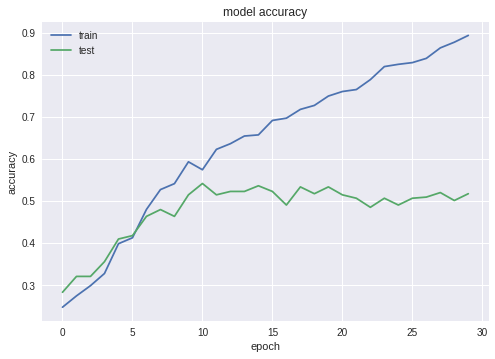

450/450 [==============================] - 1s 3ms/step
[2.0114419746398924, 0.4711111111111111]
0.4711111111111111


In [57]:
num_epochs = 30

# Create GRU model

# GRU uses less params than LSTM, for faster training
# Simple GRU model with stacked GRU layers (inspiration from NLP) - 3 layers, with dropout
# GRU layer accepts data in the form (samples, timesteps, features)

def make_GRU():
    # input is of the form: (sample, spatial, temporal)
    model = Sequential()
    model.add(Permute((2, 1), input_shape=(22, 1000)))
    
    model.add(Conv1D(filters = 64, kernel_size = 25, activation = 'elu'))
    model.add(Dropout(0.4))
    model.add(Conv1D(filters = 64, kernel_size = 25, activation = 'elu'))
    model.add(Dropout(0.4))
    
    model.add(Permute((2, 1)))
    
    # GRU layers
    model.add(GRU(128, return_sequences=True))
    model.add(GRU(128, return_sequences=True))
    model.add(GRU(64, return_sequences=True))
    
    model.add(Permute((2, 1)))
    
    model.add(Conv1D(filters = 64, kernel_size = 25, activation = 'elu'))
    model.add(Dropout(0.4))
    model.add(Conv1D(filters = 64, kernel_size = 25, activation = 'elu'))
    model.add(Dropout(0.4))
    
    model.add(Permute((2, 1)))
    
    # Dense layers
    model.add(Flatten())
    model.add(Dense(units=4, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='SGD',
                  metrics=['accuracy'])
    
    print(model.summary())
    
    return model

# make_GRU()
  
avg_acc = 0
for train_idx, test_idx in tt_splits:
    X_train = X[train_idx]
    y_train = y_cat[train_idx]
    X_test = X[test_idx]
    y_test = y_cat[test_idx]
    
    model = make_GRU()
    
    history = model.fit(X_train, y_train, validation_split=val_split, epochs=num_epochs, batch_size=batch_size)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    metrics = model.evaluate(X_test, y_test, batch_size=batch_size)
    avg_acc += metrics[1]
    print(metrics)
    break

print(avg_acc)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_52 (Permute)         (None, 1000, 22)          0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 976, 64)           35264     
_________________________________________________________________
dropout_26 (Dropout)         (None, 976, 64)           0         
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 952, 64)           102464    
_________________________________________________________________
dropout_27 (Dropout)         (None, 952, 64)           0         
_________________________________________________________________
permute_53 (Permute)         (None, 64, 952)           0         
_________________________________________________________________
lstm_24 (LSTM)               (None, 64, 128)           553472    
__________

1483/1483 [==============================] - 23s 15ms/step - loss: 1.3942 - acc: 0.2421 - val_loss: 1.3839 - val_acc: 0.2830
Epoch 2/30
1483/1483 [==============================] - 18s 12ms/step - loss: 1.3857 - acc: 0.2630 - val_loss: 1.3848 - val_acc: 0.2668
Epoch 3/30
1483/1483 [==============================] - 18s 12ms/step - loss: 1.3798 - acc: 0.2684 - val_loss: 1.3815 - val_acc: 0.2534
Epoch 4/30
1483/1483 [==============================] - 18s 12ms/step - loss: 1.3767 - acc: 0.3007 - val_loss: 1.3746 - val_acc: 0.2668
Epoch 5/30
1483/1483 [==============================] - 18s 12ms/step - loss: 1.3632 - acc: 0.3297 - val_loss: 1.3653 - val_acc: 0.3019
Epoch 6/30
 704/1483 [=============>................] - ETA: 8s - loss: 1.3570 - acc: 0.3338

1483/1483 [==============================] - 18s 12ms/step - loss: 1.3484 - acc: 0.3560 - val_loss: 1.3555 - val_acc: 0.3208
Epoch 7/30
1483/1483 [==============================] - 18s 12ms/step - loss: 1.3248 - acc: 0.3695 - val_loss: 1.3444 - val_acc: 0.3315
Epoch 8/30
1483/1483 [==============================] - 18s 12ms/step - loss: 1.3058 - acc: 0.3823 - val_loss: 1.3402 - val_acc: 0.3423
Epoch 9/30
1483/1483 [==============================] - 18s 12ms/step - loss: 1.2744 - acc: 0.4107 - val_loss: 1.3232 - val_acc: 0.3477
Epoch 10/30
1483/1483 [==============================] - 18s 12ms/step - loss: 1.2473 - acc: 0.4417 - val_loss: 1.2997 - val_acc: 0.3881
Epoch 11/30
 672/1483 [============>.................] - ETA: 9s - loss: 1.2146 - acc: 0.4271

1483/1483 [==============================] - 18s 12ms/step - loss: 1.2041 - acc: 0.4383 - val_loss: 1.2801 - val_acc: 0.4043
Epoch 12/30
1483/1483 [==============================] - 18s 12ms/step - loss: 1.1600 - acc: 0.4835 - val_loss: 1.2205 - val_acc: 0.4340
Epoch 13/30
1483/1483 [==============================] - 18s 12ms/step - loss: 1.1398 - acc: 0.4949 - val_loss: 1.2299 - val_acc: 0.4609
Epoch 14/30
1483/1483 [==============================] - 18s 12ms/step - loss: 1.1037 - acc: 0.5152 - val_loss: 1.2113 - val_acc: 0.4528
Epoch 15/30
1483/1483 [==============================] - 18s 12ms/step - loss: 1.0834 - acc: 0.5401 - val_loss: 1.2268 - val_acc: 0.4690
Epoch 16/30
 640/1483 [===========>..................] - ETA: 9s - loss: 1.0635 - acc: 0.5297

1483/1483 [==============================] - 18s 12ms/step - loss: 1.0454 - acc: 0.5455 - val_loss: 1.1986 - val_acc: 0.4798
Epoch 17/30
1483/1483 [==============================] - 18s 12ms/step - loss: 1.0106 - acc: 0.5772 - val_loss: 1.2119 - val_acc: 0.4798
Epoch 18/30
1483/1483 [==============================] - 18s 12ms/step - loss: 0.9743 - acc: 0.5934 - val_loss: 1.2095 - val_acc: 0.5013
Epoch 19/30
1483/1483 [==============================] - 18s 12ms/step - loss: 0.9212 - acc: 0.6177 - val_loss: 1.2769 - val_acc: 0.4717
Epoch 20/30
1483/1483 [==============================] - 18s 12ms/step - loss: 0.8749 - acc: 0.6419 - val_loss: 1.2553 - val_acc: 0.4825
Epoch 21/30
 640/1483 [===========>..................] - ETA: 9s - loss: 0.8134 - acc: 0.6687

1483/1483 [==============================] - 18s 12ms/step - loss: 0.8309 - acc: 0.6601 - val_loss: 1.2793 - val_acc: 0.5013
Epoch 22/30
1483/1483 [==============================] - 18s 12ms/step - loss: 0.7546 - acc: 0.7094 - val_loss: 1.3642 - val_acc: 0.4771
Epoch 23/30
1483/1483 [==============================] - 18s 12ms/step - loss: 0.7079 - acc: 0.7269 - val_loss: 1.3831 - val_acc: 0.4879
Epoch 24/30
1483/1483 [==============================] - 18s 12ms/step - loss: 0.6140 - acc: 0.7640 - val_loss: 1.5422 - val_acc: 0.4717
Epoch 25/30
1483/1483 [==============================] - 18s 12ms/step - loss: 0.5557 - acc: 0.7842 - val_loss: 1.7002 - val_acc: 0.4501
Epoch 26/30
 640/1483 [===========>..................] - ETA: 9s - loss: 0.4586 - acc: 0.8422

1483/1483 [==============================] - 18s 12ms/step - loss: 0.4879 - acc: 0.8227 - val_loss: 1.7459 - val_acc: 0.4528
Epoch 27/30
1483/1483 [==============================] - 18s 12ms/step - loss: 0.4105 - acc: 0.8503 - val_loss: 1.9453 - val_acc: 0.4286
Epoch 28/30
1483/1483 [==============================] - 18s 12ms/step - loss: 0.3171 - acc: 0.8840 - val_loss: 2.1085 - val_acc: 0.4394
Epoch 29/30
1483/1483 [==============================] - 18s 12ms/step - loss: 0.2522 - acc: 0.9184 - val_loss: 2.2660 - val_acc: 0.4555
Epoch 30/30
1483/1483 [==============================] - 18s 12ms/step - loss: 0.2197 - acc: 0.9258 - val_loss: 2.5114 - val_acc: 0.4340


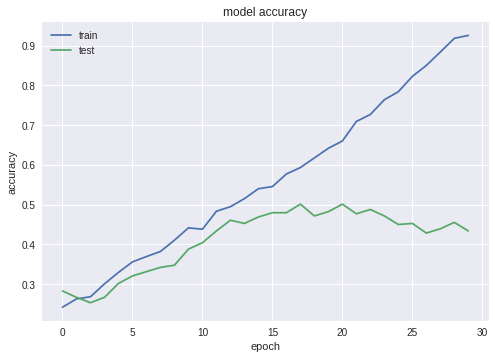

450/450 [==============================] - 2s 4ms/step
[2.383791153695848, 0.4711111111111111]
0.4711111111111111


In [60]:
num_epochs = 30

# Create GRU model

# GRU uses less params than LSTM, for faster training
# Simple GRU model with stacked GRU layers (inspiration from NLP) - 3 layers, with dropout
# GRU layer accepts data in the form (samples, timesteps, features)

def make_LSTM():
    # input is of the form: (sample, spatial, temporal)
    model = Sequential()
    model.add(Permute((2, 1), input_shape=(22, 1000)))
    
    model.add(Conv1D(filters = 64, kernel_size = 25, activation = 'elu'))
    model.add(Dropout(0.4))
    model.add(Conv1D(filters = 64, kernel_size = 25, activation = 'elu'))
    model.add(Dropout(0.4))
    
    model.add(Permute((2, 1)))
    
    # GRU layers
    model.add(LSTM(128, return_sequences=True))
    model.add(LSTM(128, return_sequences=True))
    model.add(LSTM(64, return_sequences=True))
    
    model.add(Permute((2, 1)))
    
    model.add(Conv1D(filters = 64, kernel_size = 25, activation = 'elu'))
    model.add(Dropout(0.4))
    model.add(Conv1D(filters = 64, kernel_size = 25, activation = 'elu'))
    model.add(Dropout(0.4))
    
    model.add(Permute((2, 1)))
    
    # Dense layers
    model.add(Flatten())
    model.add(Dense(units=4, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='SGD',
                  metrics=['accuracy'])
    
    print(model.summary())
    
    return model

# make_GRU()
  
avg_acc = 0
for train_idx, test_idx in tt_splits:
    X_train = X[train_idx]
    y_train = y_cat[train_idx]
    X_test = X[test_idx]
    y_test = y_cat[test_idx]
    
    model = make_LSTM()
    
    history = model.fit(X_train, y_train, validation_split=val_split, epochs=num_epochs, batch_size=batch_size)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    metrics = model.evaluate(X_test, y_test, batch_size=batch_size)
    avg_acc += metrics[1]
    print(metrics)
    break

print(avg_acc)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_63 (Permute)         (None, 1000, 22)          0         
_________________________________________________________________
reshape_12 (Reshape)         (None, 1000, 22, 1)       0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 991, 22, 25)       275       
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 991, 1, 25)        13775     
_________________________________________________________________
batch_normalization_21 (Batc (None, 991, 1, 25)        100       
_________________________________________________________________
activation_21 (Activation)   (None, 991, 1, 25)        0         
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 330, 1, 25)        0         
__________

1483/1483 [==============================] - 37s 25ms/step - loss: 1.3914 - acc: 0.2731 - val_loss: 1.3757 - val_acc: 0.2642
Epoch 2/30
1483/1483 [==============================] - 31s 21ms/step - loss: 1.3824 - acc: 0.2819 - val_loss: 1.3696 - val_acc: 0.2965
Epoch 3/30
1483/1483 [==============================] - 31s 21ms/step - loss: 1.3699 - acc: 0.3082 - val_loss: 1.3323 - val_acc: 0.3396
Epoch 4/30
1483/1483 [==============================] - 31s 21ms/step - loss: 1.3504 - acc: 0.3466 - val_loss: 1.3094 - val_acc: 0.3854
Epoch 5/30
1483/1483 [==============================] - 31s 21ms/step - loss: 1.3233 - acc: 0.3527 - val_loss: 1.2891 - val_acc: 0.3801
Epoch 6/30
 704/1483 [=============>................] - ETA: 15s - loss: 1.3050 - acc: 0.3821

1483/1483 [==============================] - 31s 21ms/step - loss: 1.3022 - acc: 0.3864 - val_loss: 1.2735 - val_acc: 0.4016
Epoch 7/30
1483/1483 [==============================] - 31s 21ms/step - loss: 1.2873 - acc: 0.3837 - val_loss: 1.2436 - val_acc: 0.3881
Epoch 8/30
1483/1483 [==============================] - 31s 21ms/step - loss: 1.2427 - acc: 0.4268 - val_loss: 1.2146 - val_acc: 0.4124
Epoch 9/30
1483/1483 [==============================] - 31s 21ms/step - loss: 1.2093 - acc: 0.4471 - val_loss: 1.2110 - val_acc: 0.4286
Epoch 10/30
1483/1483 [==============================] - 31s 21ms/step - loss: 1.1973 - acc: 0.4794 - val_loss: 1.2371 - val_acc: 0.4205
Epoch 11/30
 672/1483 [============>.................] - ETA: 15s - loss: 1.1824 - acc: 0.4732

1483/1483 [==============================] - 31s 21ms/step - loss: 1.1744 - acc: 0.4862 - val_loss: 1.1985 - val_acc: 0.4367
Epoch 12/30
1483/1483 [==============================] - 31s 21ms/step - loss: 1.1476 - acc: 0.4943 - val_loss: 1.1865 - val_acc: 0.4609
Epoch 13/30
1483/1483 [==============================] - 31s 21ms/step - loss: 1.1172 - acc: 0.5158 - val_loss: 1.1691 - val_acc: 0.4555
Epoch 14/30
1483/1483 [==============================] - 31s 21ms/step - loss: 1.1084 - acc: 0.5307 - val_loss: 1.1517 - val_acc: 0.4771
Epoch 15/30
1483/1483 [==============================] - 31s 21ms/step - loss: 1.0951 - acc: 0.5469 - val_loss: 1.2288 - val_acc: 0.4690
Epoch 16/30
 640/1483 [===========>..................] - ETA: 16s - loss: 1.0784 - acc: 0.5437

1483/1483 [==============================] - 31s 21ms/step - loss: 1.0919 - acc: 0.5489 - val_loss: 1.2836 - val_acc: 0.4394
Epoch 17/30
1483/1483 [==============================] - 31s 21ms/step - loss: 1.0688 - acc: 0.5502 - val_loss: 1.2493 - val_acc: 0.4609
Epoch 18/30
1483/1483 [==============================] - 31s 21ms/step - loss: 1.0727 - acc: 0.5502 - val_loss: 1.1857 - val_acc: 0.4879
Epoch 19/30
1483/1483 [==============================] - 31s 21ms/step - loss: 1.0366 - acc: 0.5813 - val_loss: 1.2018 - val_acc: 0.4636
Epoch 20/30
1483/1483 [==============================] - 31s 21ms/step - loss: 1.0530 - acc: 0.5550 - val_loss: 1.1692 - val_acc: 0.4852
Epoch 21/30
 640/1483 [===========>..................] - ETA: 16s - loss: 1.0541 - acc: 0.5609

1483/1483 [==============================] - 31s 21ms/step - loss: 1.0334 - acc: 0.5840 - val_loss: 1.1626 - val_acc: 0.4771
Epoch 22/30
1483/1483 [==============================] - 31s 21ms/step - loss: 1.0292 - acc: 0.5779 - val_loss: 1.1436 - val_acc: 0.5094
Epoch 23/30
1483/1483 [==============================] - 31s 21ms/step - loss: 1.0260 - acc: 0.5786 - val_loss: 1.3349 - val_acc: 0.4259
Epoch 24/30
1483/1483 [==============================] - 31s 21ms/step - loss: 1.0018 - acc: 0.5826 - val_loss: 1.1476 - val_acc: 0.4933
Epoch 25/30
1483/1483 [==============================] - 31s 21ms/step - loss: 1.0146 - acc: 0.5806 - val_loss: 1.2007 - val_acc: 0.4879
Epoch 26/30
 640/1483 [===========>..................] - ETA: 16s - loss: 1.0057 - acc: 0.6047

1483/1483 [==============================] - 31s 21ms/step - loss: 0.9989 - acc: 0.5914 - val_loss: 1.1611 - val_acc: 0.4933
Epoch 27/30
1483/1483 [==============================] - 31s 21ms/step - loss: 0.9999 - acc: 0.5947 - val_loss: 1.1365 - val_acc: 0.5175
Epoch 28/30
1483/1483 [==============================] - 31s 21ms/step - loss: 0.9961 - acc: 0.5880 - val_loss: 1.1277 - val_acc: 0.5094
Epoch 29/30
1483/1483 [==============================] - 31s 21ms/step - loss: 0.9887 - acc: 0.6001 - val_loss: 1.1808 - val_acc: 0.4879
Epoch 30/30
1483/1483 [==============================] - 31s 21ms/step - loss: 0.9939 - acc: 0.5914 - val_loss: 1.1461 - val_acc: 0.4987


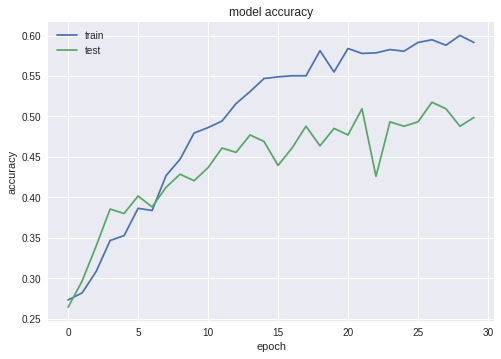

450/450 [==============================] - 2s 4ms/step
[1.0866218821207683, 0.5333333333333333]
0.5333333333333333


In [75]:
num_epochs = 30

# Create GRU model

# GRU uses less params than LSTM, for faster training
# Simple GRU model with stacked GRU layers (inspiration from NLP) - 3 layers, with dropout
# GRU layer accepts data in the form (samples, timesteps, features)

def make_GRU():
    # input is of the form: (sample, spatial, temporal)
    model = Sequential()
    
    model.add(Permute((2, 1), input_shape=(22, 1000)))
    model.add(Reshape((1000, 22, 1)))
    
    model.add(Conv2D(filters=25, kernel_size=(10,1), kernel_initializer = 'glorot_normal', strides=1, data_format="channels_last"))
    #print(model.output_shape)
    model.add(Conv2D(filters=25, kernel_size=(1,22), kernel_initializer = 'glorot_normal' ))
    model.add(BatchNormalization())
    model.add(Activation(activation = 'elu'))
    model.add(MaxPooling2D(pool_size = (3,1), strides = (3,1)))
    model.add(Dropout(0.5))

    # Conv Pool Block 2
    model.add(Conv2D(filters = 50, kernel_size = (10,1), activation = 'elu', kernel_initializer = 'glorot_normal'))
    model.add(BatchNormalization())
    model.add(Activation(activation = 'elu'))
    model.add(MaxPooling2D(pool_size = (3,1), strides = (3,1)))
    model.add(Dropout(0.5))
    
    model.add(Permute((1, 3, 2)))
    model.add(Reshape((107, 50)))
    
    # GRU layers
    model.add(GRU(32, return_sequences=True))
    model.add(GRU(32, return_sequences=True))
    model.add(GRU(32, return_sequences=True))
    model.add(GRU(32, return_sequences=True))
    
    # Dense layers
    model.add(Flatten())
    model.add(Dense(units=4, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='SGD',
                  metrics=['accuracy'])
    
    print(model.summary())
    
    return model

# make_GRU()
  
avg_acc = 0
for train_idx, test_idx in tt_splits:
    X_train = X[train_idx]
    y_train = y_cat[train_idx]
    X_test = X[test_idx]
    y_test = y_cat[test_idx]
    
    model = make_GRU()
    
    history = model.fit(X_train, y_train, validation_split=val_split, epochs=num_epochs, batch_size=batch_size)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    metrics = model.evaluate(X_test, y_test, batch_size=batch_size)
    avg_acc += metrics[1]
    print(metrics)
    break

print(avg_acc)

This model can probably be trained for more epochs or at a higher learning rate - the validation accuracy is still increasing, and the training accuracy is not increasing much faster than the val accuracy. Adding the convolutional layers at the start was good (because it preprocessed the data).

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_11 (Permute)         (None, 1000, 22)          0         
_________________________________________________________________
reshape_11 (Reshape)         (None, 1000, 22, 1)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 991, 22, 25)       275       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 991, 1, 25)        13775     
_________________________________________________________________
batch_normalization_11 (Batc (None, 991, 1, 25)        100       
_________________________________________________________________
activation_11 (Activation)   (None, 991, 1, 25)        0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 330, 1, 25)        0         
__________

1483/1483 [==============================] - 32s 22ms/step - loss: 1.3910 - acc: 0.2515 - val_loss: 1.3825 - val_acc: 0.2749
Epoch 2/50
1483/1483 [==============================] - 29s 20ms/step - loss: 1.3738 - acc: 0.2900 - val_loss: 1.3614 - val_acc: 0.3235
Epoch 3/50
1483/1483 [==============================] - 29s 20ms/step - loss: 1.3463 - acc: 0.3547 - val_loss: 1.3332 - val_acc: 0.3720
Epoch 4/50
1483/1483 [==============================] - 29s 20ms/step - loss: 1.3214 - acc: 0.3796 - val_loss: 1.3106 - val_acc: 0.3801
Epoch 5/50
1483/1483 [==============================] - 29s 20ms/step - loss: 1.2877 - acc: 0.3877 - val_loss: 1.2881 - val_acc: 0.3854
Epoch 6/50
 704/1483 [=============>................] - ETA: 14s - loss: 1.2627 - acc: 0.4134

1483/1483 [==============================] - 29s 20ms/step - loss: 1.2532 - acc: 0.4147 - val_loss: 1.2325 - val_acc: 0.4474
Epoch 7/50
1483/1483 [==============================] - 29s 20ms/step - loss: 1.2166 - acc: 0.4410 - val_loss: 1.2060 - val_acc: 0.4636
Epoch 8/50
1483/1483 [==============================] - 29s 19ms/step - loss: 1.2073 - acc: 0.4437 - val_loss: 1.1876 - val_acc: 0.4717
Epoch 9/50
1483/1483 [==============================] - 29s 19ms/step - loss: 1.1931 - acc: 0.4552 - val_loss: 1.1954 - val_acc: 0.4717
Epoch 10/50
1483/1483 [==============================] - 29s 20ms/step - loss: 1.1726 - acc: 0.4754 - val_loss: 1.1977 - val_acc: 0.4717
Epoch 11/50
 672/1483 [============>.................] - ETA: 14s - loss: 1.1772 - acc: 0.4568

1483/1483 [==============================] - 29s 20ms/step - loss: 1.1644 - acc: 0.4720 - val_loss: 1.1941 - val_acc: 0.4663
Epoch 12/50
1483/1483 [==============================] - 29s 20ms/step - loss: 1.1415 - acc: 0.5010 - val_loss: 1.2157 - val_acc: 0.4636
Epoch 13/50
1483/1483 [==============================] - 29s 20ms/step - loss: 1.1239 - acc: 0.5003 - val_loss: 1.1581 - val_acc: 0.4879
Epoch 14/50
1483/1483 [==============================] - 29s 20ms/step - loss: 1.1085 - acc: 0.5118 - val_loss: 1.1352 - val_acc: 0.5121
Epoch 15/50
1483/1483 [==============================] - 29s 20ms/step - loss: 1.1018 - acc: 0.5273 - val_loss: 1.1256 - val_acc: 0.4960
Epoch 16/50
 640/1483 [===========>..................] - ETA: 15s - loss: 1.0803 - acc: 0.5391

1483/1483 [==============================] - 29s 20ms/step - loss: 1.0643 - acc: 0.5651 - val_loss: 1.2801 - val_acc: 0.4367
Epoch 17/50
1483/1483 [==============================] - 29s 20ms/step - loss: 1.0572 - acc: 0.5462 - val_loss: 1.1496 - val_acc: 0.5094
Epoch 18/50
1483/1483 [==============================] - 29s 20ms/step - loss: 1.0438 - acc: 0.5442 - val_loss: 1.1961 - val_acc: 0.5067
Epoch 19/50
1483/1483 [==============================] - 29s 19ms/step - loss: 1.0304 - acc: 0.5738 - val_loss: 1.1546 - val_acc: 0.5256
Epoch 20/50
1483/1483 [==============================] - 29s 20ms/step - loss: 1.0375 - acc: 0.5630 - val_loss: 1.1639 - val_acc: 0.5229
Epoch 21/50
 640/1483 [===========>..................] - ETA: 15s - loss: 1.0464 - acc: 0.5828

1483/1483 [==============================] - 29s 20ms/step - loss: 1.0242 - acc: 0.5819 - val_loss: 1.0854 - val_acc: 0.5606
Epoch 22/50
1483/1483 [==============================] - 29s 20ms/step - loss: 1.0145 - acc: 0.5664 - val_loss: 1.2144 - val_acc: 0.4987
Epoch 23/50
1483/1483 [==============================] - 29s 20ms/step - loss: 1.0252 - acc: 0.5698 - val_loss: 1.0971 - val_acc: 0.5418
Epoch 24/50
1483/1483 [==============================] - 30s 20ms/step - loss: 1.0100 - acc: 0.5866 - val_loss: 1.1321 - val_acc: 0.5418
Epoch 25/50
1483/1483 [==============================] - 29s 20ms/step - loss: 0.9931 - acc: 0.5806 - val_loss: 1.2617 - val_acc: 0.5040
Epoch 26/50
 640/1483 [===========>..................] - ETA: 15s - loss: 0.9726 - acc: 0.5734

1483/1483 [==============================] - 29s 20ms/step - loss: 0.9900 - acc: 0.5866 - val_loss: 1.1029 - val_acc: 0.5526
Epoch 27/50
1483/1483 [==============================] - 29s 20ms/step - loss: 0.9671 - acc: 0.6129 - val_loss: 1.0480 - val_acc: 0.5714
Epoch 28/50
1483/1483 [==============================] - 29s 20ms/step - loss: 0.9660 - acc: 0.6049 - val_loss: 1.0729 - val_acc: 0.5633
Epoch 29/50
1483/1483 [==============================] - 29s 20ms/step - loss: 0.9603 - acc: 0.6035 - val_loss: 1.0796 - val_acc: 0.5687
Epoch 30/50
1483/1483 [==============================] - 29s 20ms/step - loss: 0.9607 - acc: 0.6096 - val_loss: 1.1393 - val_acc: 0.5418
Epoch 31/50
 640/1483 [===========>..................] - ETA: 15s - loss: 0.9608 - acc: 0.6156

1483/1483 [==============================] - 29s 20ms/step - loss: 0.9466 - acc: 0.6224 - val_loss: 1.0781 - val_acc: 0.5741
Epoch 32/50
1483/1483 [==============================] - 29s 20ms/step - loss: 0.9465 - acc: 0.6028 - val_loss: 1.1230 - val_acc: 0.5660
Epoch 33/50
1483/1483 [==============================] - 30s 20ms/step - loss: 0.9362 - acc: 0.6197 - val_loss: 1.0494 - val_acc: 0.5768
Epoch 34/50
1483/1483 [==============================] - 29s 20ms/step - loss: 0.9449 - acc: 0.6251 - val_loss: 1.0943 - val_acc: 0.5633
Epoch 35/50
1483/1483 [==============================] - 29s 20ms/step - loss: 0.9234 - acc: 0.6271 - val_loss: 1.2028 - val_acc: 0.5283
Epoch 36/50
 640/1483 [===========>..................] - ETA: 15s - loss: 0.9289 - acc: 0.6078

1483/1483 [==============================] - 29s 20ms/step - loss: 0.9230 - acc: 0.6217 - val_loss: 1.0888 - val_acc: 0.5714
Epoch 37/50
1483/1483 [==============================] - 30s 20ms/step - loss: 0.9269 - acc: 0.6231 - val_loss: 1.1372 - val_acc: 0.5606
Epoch 38/50
1483/1483 [==============================] - 30s 20ms/step - loss: 0.9230 - acc: 0.6244 - val_loss: 1.1058 - val_acc: 0.5768
Epoch 39/50
1483/1483 [==============================] - 29s 20ms/step - loss: 0.9146 - acc: 0.6258 - val_loss: 1.0633 - val_acc: 0.5957
Epoch 40/50
1483/1483 [==============================] - 29s 20ms/step - loss: 0.8935 - acc: 0.6285 - val_loss: 1.0952 - val_acc: 0.5795
Epoch 41/50
 640/1483 [===========>..................] - ETA: 15s - loss: 0.8951 - acc: 0.6422

1483/1483 [==============================] - 29s 20ms/step - loss: 0.9003 - acc: 0.6352 - val_loss: 1.0927 - val_acc: 0.5876
Epoch 42/50
1483/1483 [==============================] - 30s 20ms/step - loss: 0.9106 - acc: 0.6379 - val_loss: 1.0773 - val_acc: 0.5957
Epoch 43/50
1483/1483 [==============================] - 30s 20ms/step - loss: 0.8844 - acc: 0.6339 - val_loss: 1.1488 - val_acc: 0.5714
Epoch 44/50
1483/1483 [==============================] - 30s 20ms/step - loss: 0.8881 - acc: 0.6426 - val_loss: 1.0537 - val_acc: 0.5984
Epoch 45/50
1483/1483 [==============================] - 30s 20ms/step - loss: 0.8822 - acc: 0.6352 - val_loss: 1.0420 - val_acc: 0.5876
Epoch 46/50
 640/1483 [===========>..................] - ETA: 15s - loss: 0.8392 - acc: 0.6578

1483/1483 [==============================] - 29s 20ms/step - loss: 0.8708 - acc: 0.6413 - val_loss: 1.0424 - val_acc: 0.6092
Epoch 47/50
1483/1483 [==============================] - 30s 20ms/step - loss: 0.8627 - acc: 0.6426 - val_loss: 1.2074 - val_acc: 0.5472
Epoch 48/50
1483/1483 [==============================] - 30s 20ms/step - loss: 0.8681 - acc: 0.6541 - val_loss: 1.1291 - val_acc: 0.5876
Epoch 49/50
1483/1483 [==============================] - 30s 20ms/step - loss: 0.8640 - acc: 0.6521 - val_loss: 1.0608 - val_acc: 0.5822
Epoch 50/50
1483/1483 [==============================] - 29s 20ms/step - loss: 0.8557 - acc: 0.6514 - val_loss: 1.0856 - val_acc: 0.5876


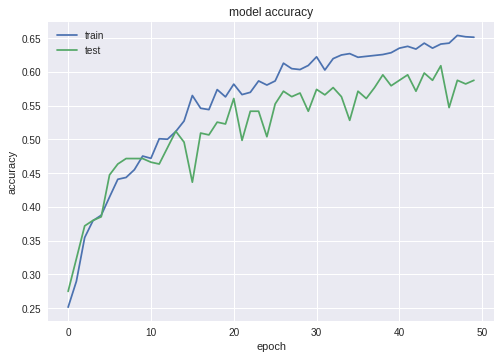

450/450 [==============================] - 2s 4ms/step
[1.057292206287384, 0.5644444444444444]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_13 (Permute)         (None, 1000, 22)          0         
_________________________________________________________________
reshape_13 (Reshape)         (None, 1000, 22, 1)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 991, 22, 25)       275       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 991, 1, 25)        13775     
_________________________________________________________________
batch_normalization_13 (Batc (None, 991, 1, 25)        100       
_________________________________________________________________
activation_13 (Activation)   (None, 991, 1, 25)        0         
_______________________________________________

1483/1483 [==============================] - 33s 22ms/step - loss: 1.3860 - acc: 0.2704 - val_loss: 1.3771 - val_acc: 0.2803
Epoch 2/50
1483/1483 [==============================] - 30s 20ms/step - loss: 1.3830 - acc: 0.2738 - val_loss: 1.3595 - val_acc: 0.3154
Epoch 3/50
1483/1483 [==============================] - 30s 20ms/step - loss: 1.3564 - acc: 0.3351 - val_loss: 1.3373 - val_acc: 0.3450
Epoch 4/50
1483/1483 [==============================] - 30s 20ms/step - loss: 1.3223 - acc: 0.3682 - val_loss: 1.3260 - val_acc: 0.3315
Epoch 5/50
1483/1483 [==============================] - 30s 20ms/step - loss: 1.2913 - acc: 0.4005 - val_loss: 1.2857 - val_acc: 0.3747
Epoch 6/50
 704/1483 [=============>................] - ETA: 14s - loss: 1.2531 - acc: 0.4318

1483/1483 [==============================] - 30s 20ms/step - loss: 1.2617 - acc: 0.4214 - val_loss: 1.2648 - val_acc: 0.3935
Epoch 7/50
1483/1483 [==============================] - 30s 20ms/step - loss: 1.2223 - acc: 0.4390 - val_loss: 1.2627 - val_acc: 0.4178
Epoch 8/50
1483/1483 [==============================] - 30s 20ms/step - loss: 1.1889 - acc: 0.4740 - val_loss: 1.2617 - val_acc: 0.4259
Epoch 9/50
1483/1483 [==============================] - 30s 20ms/step - loss: 1.1699 - acc: 0.4875 - val_loss: 1.2117 - val_acc: 0.4151
Epoch 10/50
1483/1483 [==============================] - 30s 20ms/step - loss: 1.1691 - acc: 0.4862 - val_loss: 1.2154 - val_acc: 0.4609
Epoch 11/50
 672/1483 [============>.................] - ETA: 15s - loss: 1.1157 - acc: 0.5208

1483/1483 [==============================] - 30s 20ms/step - loss: 1.1348 - acc: 0.5078 - val_loss: 1.2024 - val_acc: 0.4367
Epoch 12/50
1483/1483 [==============================] - 30s 20ms/step - loss: 1.1350 - acc: 0.5111 - val_loss: 1.2080 - val_acc: 0.4528
Epoch 13/50
1483/1483 [==============================] - 30s 20ms/step - loss: 1.1182 - acc: 0.5118 - val_loss: 1.2063 - val_acc: 0.4744
Epoch 14/50
1483/1483 [==============================] - 30s 20ms/step - loss: 1.1100 - acc: 0.5273 - val_loss: 1.2205 - val_acc: 0.4501
Epoch 15/50
1483/1483 [==============================] - 30s 20ms/step - loss: 1.1054 - acc: 0.5179 - val_loss: 1.2290 - val_acc: 0.4852
Epoch 16/50
 640/1483 [===========>..................] - ETA: 15s - loss: 1.0747 - acc: 0.5469

1483/1483 [==============================] - 30s 20ms/step - loss: 1.0830 - acc: 0.5421 - val_loss: 1.1740 - val_acc: 0.4825
Epoch 17/50
1483/1483 [==============================] - 30s 20ms/step - loss: 1.0742 - acc: 0.5334 - val_loss: 1.1716 - val_acc: 0.4906
Epoch 18/50
1483/1483 [==============================] - 29s 20ms/step - loss: 1.0609 - acc: 0.5381 - val_loss: 1.1858 - val_acc: 0.5013
Epoch 19/50
1483/1483 [==============================] - 29s 20ms/step - loss: 1.0537 - acc: 0.5597 - val_loss: 1.1929 - val_acc: 0.5040
Epoch 20/50
1483/1483 [==============================] - 29s 20ms/step - loss: 1.0470 - acc: 0.5637 - val_loss: 1.2142 - val_acc: 0.4717
Epoch 21/50
 640/1483 [===========>..................] - ETA: 15s - loss: 1.0141 - acc: 0.5813

1483/1483 [==============================] - 29s 20ms/step - loss: 1.0349 - acc: 0.5590 - val_loss: 1.1834 - val_acc: 0.5148
Epoch 22/50
1483/1483 [==============================] - 29s 20ms/step - loss: 1.0314 - acc: 0.5691 - val_loss: 1.2476 - val_acc: 0.4636
Epoch 23/50
1483/1483 [==============================] - 29s 20ms/step - loss: 1.0198 - acc: 0.5691 - val_loss: 1.1970 - val_acc: 0.4717
Epoch 24/50
1483/1483 [==============================] - 29s 20ms/step - loss: 1.0019 - acc: 0.5833 - val_loss: 1.2024 - val_acc: 0.5175
Epoch 25/50
1483/1483 [==============================] - 30s 20ms/step - loss: 1.0021 - acc: 0.5866 - val_loss: 1.1555 - val_acc: 0.5256
Epoch 26/50
 640/1483 [===========>..................] - ETA: 15s - loss: 0.9952 - acc: 0.5844

1483/1483 [==============================] - 29s 20ms/step - loss: 1.0041 - acc: 0.5826 - val_loss: 1.1768 - val_acc: 0.4933
Epoch 27/50
1483/1483 [==============================] - 30s 20ms/step - loss: 1.0039 - acc: 0.5920 - val_loss: 1.1507 - val_acc: 0.5256
Epoch 28/50
1483/1483 [==============================] - 30s 20ms/step - loss: 0.9913 - acc: 0.5873 - val_loss: 1.1481 - val_acc: 0.5175
Epoch 29/50
1483/1483 [==============================] - 29s 20ms/step - loss: 0.9753 - acc: 0.5947 - val_loss: 1.2710 - val_acc: 0.4933
Epoch 30/50
1483/1483 [==============================] - 30s 20ms/step - loss: 0.9714 - acc: 0.5968 - val_loss: 1.1669 - val_acc: 0.5040
Epoch 31/50
 640/1483 [===========>..................] - ETA: 15s - loss: 0.9340 - acc: 0.6312

1483/1483 [==============================] - 29s 20ms/step - loss: 0.9627 - acc: 0.6082 - val_loss: 1.1674 - val_acc: 0.5175
Epoch 32/50
1483/1483 [==============================] - 30s 20ms/step - loss: 0.9604 - acc: 0.6089 - val_loss: 1.1511 - val_acc: 0.5094
Epoch 33/50
1483/1483 [==============================] - 29s 20ms/step - loss: 0.9339 - acc: 0.6305 - val_loss: 1.2212 - val_acc: 0.5121
Epoch 34/50
1483/1483 [==============================] - 30s 20ms/step - loss: 0.9519 - acc: 0.6204 - val_loss: 1.1432 - val_acc: 0.5121
Epoch 35/50
1483/1483 [==============================] - 29s 20ms/step - loss: 0.9451 - acc: 0.6035 - val_loss: 1.1853 - val_acc: 0.5256
Epoch 36/50
 640/1483 [===========>..................] - ETA: 15s - loss: 0.9391 - acc: 0.6125

1483/1483 [==============================] - 29s 20ms/step - loss: 0.9305 - acc: 0.6129 - val_loss: 1.1815 - val_acc: 0.4906
Epoch 37/50
1483/1483 [==============================] - 29s 20ms/step - loss: 0.9256 - acc: 0.6177 - val_loss: 1.1546 - val_acc: 0.5337
Epoch 38/50
1483/1483 [==============================] - 30s 20ms/step - loss: 0.9237 - acc: 0.6278 - val_loss: 1.1775 - val_acc: 0.5283
Epoch 39/50
1483/1483 [==============================] - 30s 20ms/step - loss: 0.9180 - acc: 0.6156 - val_loss: 1.1229 - val_acc: 0.5418
Epoch 40/50
1483/1483 [==============================] - 30s 20ms/step - loss: 0.9024 - acc: 0.6507 - val_loss: 1.1516 - val_acc: 0.5310
Epoch 41/50
 640/1483 [===========>..................] - ETA: 15s - loss: 0.9129 - acc: 0.6344

1483/1483 [==============================] - 29s 20ms/step - loss: 0.8849 - acc: 0.6487 - val_loss: 1.1723 - val_acc: 0.5445
Epoch 42/50
1483/1483 [==============================] - 30s 20ms/step - loss: 0.8939 - acc: 0.6372 - val_loss: 1.1805 - val_acc: 0.5310
Epoch 43/50
1483/1483 [==============================] - 29s 20ms/step - loss: 0.8825 - acc: 0.6433 - val_loss: 1.2036 - val_acc: 0.4987
Epoch 44/50
1483/1483 [==============================] - 29s 20ms/step - loss: 0.8719 - acc: 0.6460 - val_loss: 1.1153 - val_acc: 0.5499
Epoch 45/50
1483/1483 [==============================] - 29s 20ms/step - loss: 0.8746 - acc: 0.6628 - val_loss: 1.1643 - val_acc: 0.4987
Epoch 46/50
 640/1483 [===========>..................] - ETA: 15s - loss: 0.8047 - acc: 0.6844

1483/1483 [==============================] - 30s 20ms/step - loss: 0.8605 - acc: 0.6642 - val_loss: 1.1291 - val_acc: 0.5229
Epoch 47/50
1483/1483 [==============================] - 30s 20ms/step - loss: 0.8648 - acc: 0.6581 - val_loss: 1.1702 - val_acc: 0.5337
Epoch 48/50
1483/1483 [==============================] - 29s 20ms/step - loss: 0.8554 - acc: 0.6615 - val_loss: 1.1451 - val_acc: 0.5256
Epoch 49/50
1483/1483 [==============================] - 29s 20ms/step - loss: 0.8599 - acc: 0.6548 - val_loss: 1.1634 - val_acc: 0.5121
Epoch 50/50
1483/1483 [==============================] - 29s 20ms/step - loss: 0.8456 - acc: 0.6601 - val_loss: 1.1951 - val_acc: 0.5121


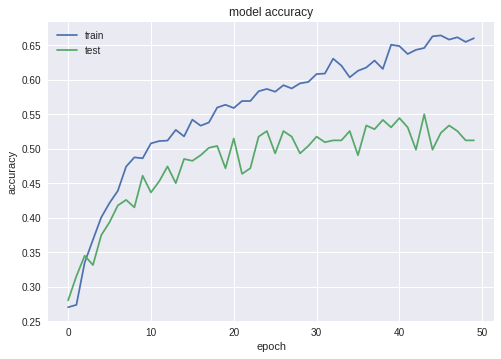

450/450 [==============================] - 2s 4ms/step
[1.10748774766922, 0.5577777777777778]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_15 (Permute)         (None, 1000, 22)          0         
_________________________________________________________________
reshape_15 (Reshape)         (None, 1000, 22, 1)       0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 991, 22, 25)       275       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 991, 1, 25)        13775     
_________________________________________________________________
batch_normalization_15 (Batc (None, 991, 1, 25)        100       
_________________________________________________________________
activation_15 (Activation)   (None, 991, 1, 25)        0         
________________________________________________

1483/1483 [==============================] - 33s 22ms/step - loss: 1.3982 - acc: 0.2299 - val_loss: 1.3952 - val_acc: 0.2453
Epoch 2/50
1483/1483 [==============================] - 30s 20ms/step - loss: 1.3911 - acc: 0.2542 - val_loss: 1.3983 - val_acc: 0.2426
Epoch 3/50
1483/1483 [==============================] - 30s 20ms/step - loss: 1.3836 - acc: 0.2825 - val_loss: 1.3831 - val_acc: 0.2588
Epoch 4/50
1483/1483 [==============================] - 30s 20ms/step - loss: 1.3784 - acc: 0.2886 - val_loss: 1.3662 - val_acc: 0.3208
Epoch 5/50
1483/1483 [==============================] - 29s 20ms/step - loss: 1.3725 - acc: 0.3122 - val_loss: 1.3561 - val_acc: 0.3396
Epoch 6/50
 672/1483 [============>.................] - ETA: 15s - loss: 1.3628 - acc: 0.3348

1483/1483 [==============================] - 30s 20ms/step - loss: 1.3572 - acc: 0.3486 - val_loss: 1.3416 - val_acc: 0.3477
Epoch 7/50
1483/1483 [==============================] - 30s 20ms/step - loss: 1.3437 - acc: 0.3547 - val_loss: 1.3305 - val_acc: 0.3423
Epoch 8/50
1483/1483 [==============================] - 30s 20ms/step - loss: 1.3166 - acc: 0.3830 - val_loss: 1.3042 - val_acc: 0.3666
Epoch 9/50
1483/1483 [==============================] - 30s 20ms/step - loss: 1.2877 - acc: 0.4080 - val_loss: 1.2633 - val_acc: 0.3854
Epoch 10/50
1483/1483 [==============================] - 29s 20ms/step - loss: 1.2544 - acc: 0.4329 - val_loss: 1.2321 - val_acc: 0.4232
Epoch 11/50
 672/1483 [============>.................] - ETA: 15s - loss: 1.2093 - acc: 0.4628

1483/1483 [==============================] - 29s 20ms/step - loss: 1.2217 - acc: 0.4417 - val_loss: 1.2314 - val_acc: 0.4340
Epoch 12/50
1483/1483 [==============================] - 29s 20ms/step - loss: 1.2072 - acc: 0.4552 - val_loss: 1.2238 - val_acc: 0.4771
Epoch 13/50
1483/1483 [==============================] - 29s 20ms/step - loss: 1.1897 - acc: 0.4761 - val_loss: 1.1973 - val_acc: 0.4636
Epoch 14/50
1483/1483 [==============================] - 29s 20ms/step - loss: 1.1952 - acc: 0.4734 - val_loss: 1.1867 - val_acc: 0.4798
Epoch 15/50
1483/1483 [==============================] - 29s 20ms/step - loss: 1.1744 - acc: 0.4740 - val_loss: 1.2094 - val_acc: 0.4501
Epoch 16/50
 640/1483 [===========>..................] - ETA: 15s - loss: 1.1718 - acc: 0.4797

1483/1483 [==============================] - 29s 20ms/step - loss: 1.1664 - acc: 0.4869 - val_loss: 1.2446 - val_acc: 0.4474
Epoch 17/50
1483/1483 [==============================] - 29s 20ms/step - loss: 1.1564 - acc: 0.4902 - val_loss: 1.2281 - val_acc: 0.4636
Epoch 18/50
1483/1483 [==============================] - 29s 20ms/step - loss: 1.1376 - acc: 0.5017 - val_loss: 1.2260 - val_acc: 0.4582
Epoch 19/50
1483/1483 [==============================] - 29s 20ms/step - loss: 1.1338 - acc: 0.5192 - val_loss: 1.1721 - val_acc: 0.4771
Epoch 20/50
1483/1483 [==============================] - 29s 20ms/step - loss: 1.1049 - acc: 0.5388 - val_loss: 1.1816 - val_acc: 0.4717
Epoch 21/50
 640/1483 [===========>..................] - ETA: 15s - loss: 1.0746 - acc: 0.5422

1483/1483 [==============================] - 29s 20ms/step - loss: 1.1085 - acc: 0.5239 - val_loss: 1.1687 - val_acc: 0.4960
Epoch 22/50
1483/1483 [==============================] - 29s 20ms/step - loss: 1.0887 - acc: 0.5266 - val_loss: 1.1600 - val_acc: 0.4933
Epoch 23/50
1483/1483 [==============================] - 29s 20ms/step - loss: 1.0714 - acc: 0.5448 - val_loss: 1.1293 - val_acc: 0.5391
Epoch 24/50
1483/1483 [==============================] - 29s 20ms/step - loss: 1.0645 - acc: 0.5496 - val_loss: 1.1042 - val_acc: 0.5553
Epoch 25/50
1483/1483 [==============================] - 29s 20ms/step - loss: 1.0518 - acc: 0.5597 - val_loss: 1.0974 - val_acc: 0.5633
Epoch 26/50
 640/1483 [===========>..................] - ETA: 15s - loss: 1.0374 - acc: 0.5578

1483/1483 [==============================] - 29s 20ms/step - loss: 1.0597 - acc: 0.5577 - val_loss: 1.0906 - val_acc: 0.5633
Epoch 27/50
1483/1483 [==============================] - 29s 20ms/step - loss: 1.0352 - acc: 0.5691 - val_loss: 1.0876 - val_acc: 0.5957
Epoch 28/50
1483/1483 [==============================] - 29s 20ms/step - loss: 1.0307 - acc: 0.5624 - val_loss: 1.1814 - val_acc: 0.4933
Epoch 29/50
1483/1483 [==============================] - 29s 20ms/step - loss: 1.0174 - acc: 0.5819 - val_loss: 1.1103 - val_acc: 0.5499
Epoch 30/50
1483/1483 [==============================] - 29s 20ms/step - loss: 1.0208 - acc: 0.5779 - val_loss: 1.0988 - val_acc: 0.5768
Epoch 31/50
 640/1483 [===========>..................] - ETA: 15s - loss: 1.0540 - acc: 0.5703

1483/1483 [==============================] - 30s 20ms/step - loss: 1.0144 - acc: 0.5853 - val_loss: 1.1561 - val_acc: 0.5391
Epoch 32/50
1483/1483 [==============================] - 30s 20ms/step - loss: 1.0201 - acc: 0.5799 - val_loss: 1.0961 - val_acc: 0.5391
Epoch 33/50
1483/1483 [==============================] - 30s 20ms/step - loss: 1.0010 - acc: 0.5792 - val_loss: 1.0892 - val_acc: 0.5714
Epoch 34/50
1483/1483 [==============================] - 30s 20ms/step - loss: 0.9970 - acc: 0.5934 - val_loss: 1.0831 - val_acc: 0.5633
Epoch 35/50
1483/1483 [==============================] - 29s 20ms/step - loss: 0.9809 - acc: 0.5947 - val_loss: 1.1323 - val_acc: 0.5418
Epoch 36/50
 640/1483 [===========>..................] - ETA: 15s - loss: 1.0146 - acc: 0.5797

1483/1483 [==============================] - 30s 20ms/step - loss: 0.9820 - acc: 0.5927 - val_loss: 1.1284 - val_acc: 0.5229
Epoch 37/50
1483/1483 [==============================] - 29s 20ms/step - loss: 0.9707 - acc: 0.6055 - val_loss: 1.1608 - val_acc: 0.5229
Epoch 38/50
1483/1483 [==============================] - 29s 20ms/step - loss: 0.9721 - acc: 0.6049 - val_loss: 1.0961 - val_acc: 0.5391
Epoch 39/50
1483/1483 [==============================] - 29s 20ms/step - loss: 0.9606 - acc: 0.6129 - val_loss: 1.0496 - val_acc: 0.5714
Epoch 40/50
1483/1483 [==============================] - 29s 20ms/step - loss: 0.9598 - acc: 0.6035 - val_loss: 1.2181 - val_acc: 0.4960
Epoch 41/50
 640/1483 [===========>..................] - ETA: 15s - loss: 0.9550 - acc: 0.6281

1483/1483 [==============================] - 29s 20ms/step - loss: 0.9582 - acc: 0.6197 - val_loss: 1.1026 - val_acc: 0.5499
Epoch 42/50
1483/1483 [==============================] - 29s 20ms/step - loss: 0.9482 - acc: 0.6163 - val_loss: 1.0498 - val_acc: 0.5795
Epoch 43/50
1483/1483 [==============================] - 29s 20ms/step - loss: 0.9439 - acc: 0.5954 - val_loss: 1.0552 - val_acc: 0.5714
Epoch 44/50
1483/1483 [==============================] - 29s 20ms/step - loss: 0.9433 - acc: 0.6156 - val_loss: 1.0493 - val_acc: 0.5822
Epoch 45/50
1483/1483 [==============================] - 29s 20ms/step - loss: 0.9358 - acc: 0.6062 - val_loss: 1.0177 - val_acc: 0.5795
Epoch 46/50
 640/1483 [===========>..................] - ETA: 15s - loss: 0.9263 - acc: 0.6281

1483/1483 [==============================] - 29s 20ms/step - loss: 0.9244 - acc: 0.6285 - val_loss: 1.0952 - val_acc: 0.5903
Epoch 47/50
1483/1483 [==============================] - 29s 20ms/step - loss: 0.9357 - acc: 0.6197 - val_loss: 1.0280 - val_acc: 0.5822
Epoch 48/50
1483/1483 [==============================] - 30s 20ms/step - loss: 0.9326 - acc: 0.6204 - val_loss: 1.0819 - val_acc: 0.5741
Epoch 49/50
1483/1483 [==============================] - 29s 20ms/step - loss: 0.9157 - acc: 0.6312 - val_loss: 1.0236 - val_acc: 0.6119
Epoch 50/50
1483/1483 [==============================] - 30s 20ms/step - loss: 0.9064 - acc: 0.6298 - val_loss: 1.0199 - val_acc: 0.5984


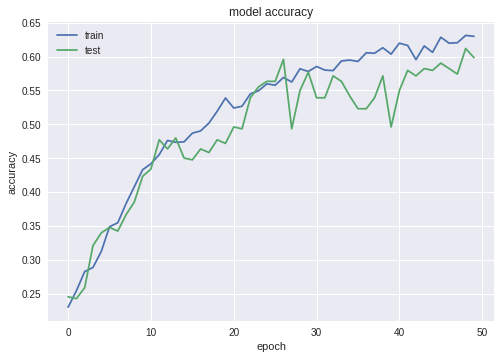

450/450 [==============================] - 2s 4ms/step
[0.9630123113261329, 0.6133333333333333]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_17 (Permute)         (None, 1000, 22)          0         
_________________________________________________________________
reshape_17 (Reshape)         (None, 1000, 22, 1)       0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 991, 22, 25)       275       
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 991, 1, 25)        13775     
_________________________________________________________________
batch_normalization_17 (Batc (None, 991, 1, 25)        100       
_________________________________________________________________
activation_17 (Activation)   (None, 991, 1, 25)        0         
______________________________________________

1483/1483 [==============================] - 33s 22ms/step - loss: 1.3786 - acc: 0.2866 - val_loss: 1.3679 - val_acc: 0.3261
Epoch 2/50
1483/1483 [==============================] - 30s 20ms/step - loss: 1.3603 - acc: 0.3372 - val_loss: 1.3444 - val_acc: 0.3450
Epoch 3/50
1483/1483 [==============================] - 30s 20ms/step - loss: 1.3305 - acc: 0.3877 - val_loss: 1.3133 - val_acc: 0.3477
Epoch 4/50
1483/1483 [==============================] - 29s 20ms/step - loss: 1.2884 - acc: 0.4005 - val_loss: 1.2814 - val_acc: 0.3720
Epoch 5/50
1483/1483 [==============================] - 29s 20ms/step - loss: 1.2444 - acc: 0.4248 - val_loss: 1.2385 - val_acc: 0.4070
Epoch 6/50
 672/1483 [============>.................] - ETA: 14s - loss: 1.1951 - acc: 0.4717

1483/1483 [==============================] - 29s 20ms/step - loss: 1.2077 - acc: 0.4552 - val_loss: 1.2534 - val_acc: 0.4124
Epoch 7/50
1483/1483 [==============================] - 29s 20ms/step - loss: 1.1890 - acc: 0.4565 - val_loss: 1.2362 - val_acc: 0.4313
Epoch 8/50
1483/1483 [==============================] - 29s 20ms/step - loss: 1.1792 - acc: 0.4794 - val_loss: 1.2423 - val_acc: 0.4205
Epoch 9/50
1483/1483 [==============================] - 29s 20ms/step - loss: 1.1593 - acc: 0.4875 - val_loss: 1.2408 - val_acc: 0.4474
Epoch 10/50
1483/1483 [==============================] - 29s 20ms/step - loss: 1.1327 - acc: 0.4983 - val_loss: 1.2460 - val_acc: 0.4555
Epoch 11/50
 672/1483 [============>.................] - ETA: 14s - loss: 1.1268 - acc: 0.5000

1483/1483 [==============================] - 29s 20ms/step - loss: 1.1418 - acc: 0.4970 - val_loss: 1.2333 - val_acc: 0.4609
Epoch 12/50
1483/1483 [==============================] - 29s 20ms/step - loss: 1.1330 - acc: 0.4922 - val_loss: 1.2118 - val_acc: 0.4582
Epoch 13/50
1483/1483 [==============================] - 29s 19ms/step - loss: 1.1101 - acc: 0.5239 - val_loss: 1.2069 - val_acc: 0.4717
Epoch 14/50
1483/1483 [==============================] - 29s 20ms/step - loss: 1.0970 - acc: 0.5300 - val_loss: 1.1929 - val_acc: 0.4798
Epoch 15/50
1483/1483 [==============================] - 29s 19ms/step - loss: 1.0696 - acc: 0.5287 - val_loss: 1.1778 - val_acc: 0.5121
Epoch 16/50
 640/1483 [===========>..................] - ETA: 15s - loss: 1.0486 - acc: 0.5641

1483/1483 [==============================] - 29s 19ms/step - loss: 1.0498 - acc: 0.5577 - val_loss: 1.3692 - val_acc: 0.3801
Epoch 17/50
1483/1483 [==============================] - 29s 20ms/step - loss: 1.0264 - acc: 0.5745 - val_loss: 1.1801 - val_acc: 0.5175
Epoch 18/50
1483/1483 [==============================] - 29s 19ms/step - loss: 1.0166 - acc: 0.5792 - val_loss: 1.1865 - val_acc: 0.5040
Epoch 19/50
1483/1483 [==============================] - 29s 20ms/step - loss: 1.0093 - acc: 0.5772 - val_loss: 1.1616 - val_acc: 0.5202
Epoch 20/50
1483/1483 [==============================] - 29s 20ms/step - loss: 0.9947 - acc: 0.5779 - val_loss: 1.1619 - val_acc: 0.5175
Epoch 21/50
 640/1483 [===========>..................] - ETA: 15s - loss: 0.9598 - acc: 0.6062

1483/1483 [==============================] - 29s 19ms/step - loss: 0.9873 - acc: 0.5934 - val_loss: 1.1876 - val_acc: 0.5337
Epoch 22/50
1483/1483 [==============================] - 29s 20ms/step - loss: 0.9835 - acc: 0.5934 - val_loss: 1.1401 - val_acc: 0.5391
Epoch 23/50
1483/1483 [==============================] - 29s 20ms/step - loss: 0.9729 - acc: 0.5968 - val_loss: 1.1482 - val_acc: 0.5364
Epoch 24/50
1483/1483 [==============================] - 29s 20ms/step - loss: 0.9561 - acc: 0.6042 - val_loss: 1.1150 - val_acc: 0.5418
Epoch 25/50
1483/1483 [==============================] - 29s 19ms/step - loss: 0.9641 - acc: 0.6062 - val_loss: 1.1483 - val_acc: 0.5391
Epoch 26/50
 640/1483 [===========>..................] - ETA: 15s - loss: 0.9311 - acc: 0.6109

1483/1483 [==============================] - 29s 20ms/step - loss: 0.9438 - acc: 0.6049 - val_loss: 1.1091 - val_acc: 0.5526
Epoch 27/50
1483/1483 [==============================] - 29s 20ms/step - loss: 0.9482 - acc: 0.6109 - val_loss: 1.0877 - val_acc: 0.5660
Epoch 28/50
1483/1483 [==============================] - 29s 20ms/step - loss: 0.9375 - acc: 0.6123 - val_loss: 1.1357 - val_acc: 0.5445
Epoch 29/50
1483/1483 [==============================] - 29s 20ms/step - loss: 0.9362 - acc: 0.6001 - val_loss: 1.1271 - val_acc: 0.5337
Epoch 30/50
1483/1483 [==============================] - 29s 20ms/step - loss: 0.9127 - acc: 0.6183 - val_loss: 1.1638 - val_acc: 0.5445
Epoch 31/50
 640/1483 [===========>..................] - ETA: 15s - loss: 0.9293 - acc: 0.6406

1483/1483 [==============================] - 29s 20ms/step - loss: 0.9059 - acc: 0.6467 - val_loss: 1.1954 - val_acc: 0.5121
Epoch 32/50
1483/1483 [==============================] - 29s 20ms/step - loss: 0.9198 - acc: 0.6204 - val_loss: 1.1140 - val_acc: 0.5472
Epoch 33/50
1483/1483 [==============================] - 29s 19ms/step - loss: 0.9094 - acc: 0.6237 - val_loss: 1.1653 - val_acc: 0.5472
Epoch 34/50
1483/1483 [==============================] - 29s 20ms/step - loss: 0.9109 - acc: 0.6433 - val_loss: 1.0855 - val_acc: 0.5580
Epoch 35/50
1483/1483 [==============================] - 29s 20ms/step - loss: 0.9060 - acc: 0.6406 - val_loss: 1.0945 - val_acc: 0.5472
Epoch 36/50
 640/1483 [===========>..................] - ETA: 15s - loss: 0.9053 - acc: 0.6375

1483/1483 [==============================] - 29s 20ms/step - loss: 0.8960 - acc: 0.6379 - val_loss: 1.1082 - val_acc: 0.5714
Epoch 37/50
1483/1483 [==============================] - 29s 19ms/step - loss: 0.8887 - acc: 0.6258 - val_loss: 1.1026 - val_acc: 0.5741
Epoch 38/50
1483/1483 [==============================] - 29s 20ms/step - loss: 0.8697 - acc: 0.6521 - val_loss: 1.0919 - val_acc: 0.5660
Epoch 39/50
1483/1483 [==============================] - 29s 20ms/step - loss: 0.8693 - acc: 0.6372 - val_loss: 1.1772 - val_acc: 0.5202
Epoch 40/50
1483/1483 [==============================] - 29s 20ms/step - loss: 0.8659 - acc: 0.6460 - val_loss: 1.0923 - val_acc: 0.5795
Epoch 41/50
 640/1483 [===========>..................] - ETA: 15s - loss: 0.8297 - acc: 0.6719

1483/1483 [==============================] - 29s 19ms/step - loss: 0.8607 - acc: 0.6473 - val_loss: 1.1258 - val_acc: 0.5499
Epoch 42/50
1483/1483 [==============================] - 29s 20ms/step - loss: 0.8673 - acc: 0.6581 - val_loss: 1.0805 - val_acc: 0.5660
Epoch 43/50
1483/1483 [==============================] - 29s 20ms/step - loss: 0.8542 - acc: 0.6507 - val_loss: 1.1165 - val_acc: 0.5499
Epoch 44/50
1483/1483 [==============================] - 29s 20ms/step - loss: 0.8561 - acc: 0.6615 - val_loss: 1.0526 - val_acc: 0.5606
Epoch 45/50
1483/1483 [==============================] - 29s 20ms/step - loss: 0.8391 - acc: 0.6689 - val_loss: 1.0774 - val_acc: 0.5633
Epoch 46/50
 640/1483 [===========>..................] - ETA: 15s - loss: 0.8547 - acc: 0.6484

1483/1483 [==============================] - 29s 19ms/step - loss: 0.8412 - acc: 0.6615 - val_loss: 1.0893 - val_acc: 0.5445
Epoch 47/50
1483/1483 [==============================] - 29s 19ms/step - loss: 0.8436 - acc: 0.6561 - val_loss: 1.1199 - val_acc: 0.5633
Epoch 48/50
1483/1483 [==============================] - 29s 19ms/step - loss: 0.8411 - acc: 0.6548 - val_loss: 1.0502 - val_acc: 0.5849
Epoch 49/50
1483/1483 [==============================] - 29s 20ms/step - loss: 0.8158 - acc: 0.6844 - val_loss: 1.0957 - val_acc: 0.5660
Epoch 50/50
1483/1483 [==============================] - 29s 20ms/step - loss: 0.8326 - acc: 0.6635 - val_loss: 1.1527 - val_acc: 0.5310


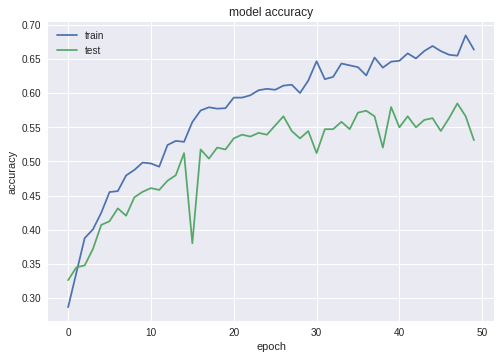

450/450 [==============================] - 2s 4ms/step
[1.0970689678192138, 0.5777777777777777]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_19 (Permute)         (None, 1000, 22)          0         
_________________________________________________________________
reshape_19 (Reshape)         (None, 1000, 22, 1)       0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 991, 22, 25)       275       
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 991, 1, 25)        13775     
_________________________________________________________________
batch_normalization_19 (Batc (None, 991, 1, 25)        100       
_________________________________________________________________
activation_19 (Activation)   (None, 991, 1, 25)        0         
______________________________________________

1483/1483 [==============================] - 33s 22ms/step - loss: 1.3858 - acc: 0.2630 - val_loss: 1.3630 - val_acc: 0.3315
Epoch 2/50
1483/1483 [==============================] - 29s 20ms/step - loss: 1.3771 - acc: 0.2953 - val_loss: 1.3462 - val_acc: 0.3315
Epoch 3/50
1483/1483 [==============================] - 29s 20ms/step - loss: 1.3593 - acc: 0.3351 - val_loss: 1.3264 - val_acc: 0.3693
Epoch 4/50
1483/1483 [==============================] - 29s 20ms/step - loss: 1.3375 - acc: 0.3425 - val_loss: 1.3127 - val_acc: 0.3639
Epoch 5/50
1483/1483 [==============================] - 29s 20ms/step - loss: 1.3170 - acc: 0.3810 - val_loss: 1.2936 - val_acc: 0.3801
Epoch 6/50
 704/1483 [=============>................] - ETA: 14s - loss: 1.2981 - acc: 0.3778

1483/1483 [==============================] - 29s 20ms/step - loss: 1.3002 - acc: 0.3884 - val_loss: 1.2777 - val_acc: 0.3881
Epoch 7/50
1483/1483 [==============================] - 29s 20ms/step - loss: 1.2772 - acc: 0.4120 - val_loss: 1.2549 - val_acc: 0.3989
Epoch 8/50
1483/1483 [==============================] - 29s 20ms/step - loss: 1.2573 - acc: 0.4295 - val_loss: 1.2231 - val_acc: 0.4582
Epoch 9/50
1483/1483 [==============================] - 29s 20ms/step - loss: 1.2341 - acc: 0.4248 - val_loss: 1.1807 - val_acc: 0.4744
Epoch 10/50
1483/1483 [==============================] - 29s 20ms/step - loss: 1.1992 - acc: 0.4673 - val_loss: 1.2152 - val_acc: 0.4528
Epoch 11/50
 672/1483 [============>.................] - ETA: 14s - loss: 1.1851 - acc: 0.4866

1483/1483 [==============================] - 29s 20ms/step - loss: 1.1835 - acc: 0.4794 - val_loss: 1.1507 - val_acc: 0.4744
Epoch 12/50
1483/1483 [==============================] - 29s 20ms/step - loss: 1.1463 - acc: 0.4956 - val_loss: 1.1388 - val_acc: 0.4879
Epoch 13/50
1483/1483 [==============================] - 29s 20ms/step - loss: 1.1431 - acc: 0.5098 - val_loss: 1.1549 - val_acc: 0.4960
Epoch 14/50
1483/1483 [==============================] - 29s 20ms/step - loss: 1.1104 - acc: 0.5192 - val_loss: 1.1293 - val_acc: 0.5067
Epoch 15/50
1483/1483 [==============================] - 29s 20ms/step - loss: 1.1011 - acc: 0.5206 - val_loss: 1.1827 - val_acc: 0.4744
Epoch 16/50
 640/1483 [===========>..................] - ETA: 15s - loss: 1.0703 - acc: 0.5531

1483/1483 [==============================] - 29s 20ms/step - loss: 1.0665 - acc: 0.5455 - val_loss: 1.1255 - val_acc: 0.4933
Epoch 17/50
1483/1483 [==============================] - 29s 20ms/step - loss: 1.0601 - acc: 0.5394 - val_loss: 1.1442 - val_acc: 0.5175
Epoch 18/50
1483/1483 [==============================] - 29s 20ms/step - loss: 1.0503 - acc: 0.5610 - val_loss: 1.1569 - val_acc: 0.4933
Epoch 19/50
1483/1483 [==============================] - 29s 20ms/step - loss: 1.0382 - acc: 0.5705 - val_loss: 1.1823 - val_acc: 0.5013
Epoch 20/50
1483/1483 [==============================] - 29s 20ms/step - loss: 1.0206 - acc: 0.5786 - val_loss: 1.1202 - val_acc: 0.5148
Epoch 21/50
 640/1483 [===========>..................] - ETA: 15s - loss: 0.9903 - acc: 0.5828

1483/1483 [==============================] - 29s 20ms/step - loss: 1.0239 - acc: 0.5597 - val_loss: 1.1207 - val_acc: 0.4933
Epoch 22/50
1483/1483 [==============================] - 30s 20ms/step - loss: 1.0119 - acc: 0.5711 - val_loss: 1.1279 - val_acc: 0.5229
Epoch 23/50
1483/1483 [==============================] - 29s 20ms/step - loss: 0.9982 - acc: 0.5819 - val_loss: 1.1547 - val_acc: 0.5121
Epoch 24/50
1483/1483 [==============================] - 29s 20ms/step - loss: 0.9996 - acc: 0.5657 - val_loss: 1.1023 - val_acc: 0.5256
Epoch 25/50
1483/1483 [==============================] - 29s 20ms/step - loss: 0.9822 - acc: 0.5981 - val_loss: 1.1211 - val_acc: 0.5229
Epoch 26/50
 640/1483 [===========>..................] - ETA: 15s - loss: 1.0068 - acc: 0.5578

1483/1483 [==============================] - 29s 20ms/step - loss: 0.9900 - acc: 0.5853 - val_loss: 1.1935 - val_acc: 0.5121
Epoch 27/50
1483/1483 [==============================] - 29s 20ms/step - loss: 0.9857 - acc: 0.5866 - val_loss: 1.1898 - val_acc: 0.5067
Epoch 28/50
1483/1483 [==============================] - 29s 20ms/step - loss: 0.9600 - acc: 0.6035 - val_loss: 1.1640 - val_acc: 0.5229
Epoch 29/50
1483/1483 [==============================] - 29s 20ms/step - loss: 0.9789 - acc: 0.5853 - val_loss: 1.1187 - val_acc: 0.5283
Epoch 30/50
1483/1483 [==============================] - 29s 20ms/step - loss: 0.9481 - acc: 0.6123 - val_loss: 1.0980 - val_acc: 0.5310
Epoch 31/50
 640/1483 [===========>..................] - ETA: 15s - loss: 0.9575 - acc: 0.6109

1483/1483 [==============================] - 29s 20ms/step - loss: 0.9552 - acc: 0.6069 - val_loss: 1.1086 - val_acc: 0.5391
Epoch 32/50
1483/1483 [==============================] - 29s 20ms/step - loss: 0.9511 - acc: 0.6170 - val_loss: 1.1378 - val_acc: 0.5229
Epoch 33/50
1483/1483 [==============================] - 29s 20ms/step - loss: 0.9369 - acc: 0.6190 - val_loss: 1.1113 - val_acc: 0.5148
Epoch 34/50
1483/1483 [==============================] - 29s 20ms/step - loss: 0.9257 - acc: 0.6217 - val_loss: 1.0878 - val_acc: 0.5256
Epoch 35/50
1483/1483 [==============================] - 29s 20ms/step - loss: 0.9341 - acc: 0.6069 - val_loss: 1.0907 - val_acc: 0.5418
Epoch 36/50
 640/1483 [===========>..................] - ETA: 15s - loss: 0.9319 - acc: 0.6281

1483/1483 [==============================] - 29s 20ms/step - loss: 0.9399 - acc: 0.6177 - val_loss: 1.1429 - val_acc: 0.5148
Epoch 37/50
1483/1483 [==============================] - 29s 20ms/step - loss: 0.9340 - acc: 0.6224 - val_loss: 1.0734 - val_acc: 0.5499
Epoch 38/50
1483/1483 [==============================] - 29s 20ms/step - loss: 0.9279 - acc: 0.6197 - val_loss: 1.1509 - val_acc: 0.5067
Epoch 39/50
1483/1483 [==============================] - 29s 20ms/step - loss: 0.9023 - acc: 0.6359 - val_loss: 1.1476 - val_acc: 0.5256
Epoch 40/50
1483/1483 [==============================] - 29s 20ms/step - loss: 0.9107 - acc: 0.6271 - val_loss: 1.0843 - val_acc: 0.5364
Epoch 41/50
 640/1483 [===========>..................] - ETA: 15s - loss: 0.9006 - acc: 0.6328

1483/1483 [==============================] - 29s 20ms/step - loss: 0.9030 - acc: 0.6339 - val_loss: 1.1004 - val_acc: 0.5310
Epoch 42/50
1483/1483 [==============================] - 29s 20ms/step - loss: 0.8922 - acc: 0.6325 - val_loss: 1.0793 - val_acc: 0.5445
Epoch 43/50
1483/1483 [==============================] - 29s 20ms/step - loss: 0.8968 - acc: 0.6386 - val_loss: 1.1303 - val_acc: 0.5256
Epoch 44/50
1483/1483 [==============================] - 29s 20ms/step - loss: 0.8968 - acc: 0.6318 - val_loss: 1.1020 - val_acc: 0.5364
Epoch 45/50
1483/1483 [==============================] - 29s 20ms/step - loss: 0.8878 - acc: 0.6521 - val_loss: 1.0765 - val_acc: 0.5445
Epoch 46/50
 640/1483 [===========>..................] - ETA: 15s - loss: 0.8695 - acc: 0.6547

1483/1483 [==============================] - 30s 20ms/step - loss: 0.8726 - acc: 0.6521 - val_loss: 1.0789 - val_acc: 0.5553
Epoch 47/50
1483/1483 [==============================] - 29s 20ms/step - loss: 0.8765 - acc: 0.6521 - val_loss: 1.0964 - val_acc: 0.5472
Epoch 48/50
1483/1483 [==============================] - 29s 20ms/step - loss: 0.8542 - acc: 0.6649 - val_loss: 1.0687 - val_acc: 0.5768
Epoch 49/50
1483/1483 [==============================] - 29s 20ms/step - loss: 0.8736 - acc: 0.6494 - val_loss: 1.0963 - val_acc: 0.5526
Epoch 50/50
1483/1483 [==============================] - 29s 20ms/step - loss: 0.8704 - acc: 0.6595 - val_loss: 1.0786 - val_acc: 0.5310


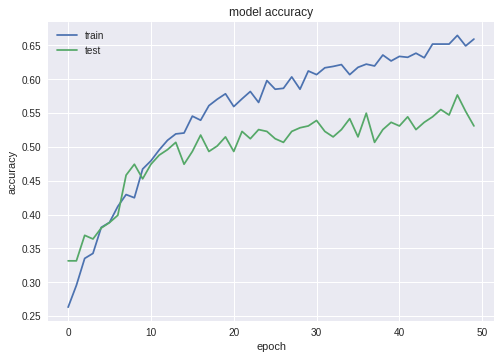

450/450 [==============================] - 2s 4ms/step
[1.0249688397513494, 0.5733333333333334]
0.5773333333333334


In [14]:
# Best model so far; do 5-fold cross validation and see if the results still hold.

num_epochs = 50

# Create GRU model

# GRU uses less params than LSTM, for faster training
# Simple GRU model with stacked GRU layers (inspiration from NLP) - 3 layers, with dropout
# GRU layer accepts data in the form (samples, timesteps, features)

def make_GRU():
    # input is of the form: (sample, spatial, temporal)
    model = Sequential()
    
    model.add(Permute((2, 1), input_shape=(22, 1000)))
    model.add(Reshape((1000, 22, 1)))
    
    model.add(Conv2D(filters=25, kernel_size=(10,1), kernel_initializer = 'glorot_normal', strides=1, data_format="channels_last"))
    #print(model.output_shape)
    model.add(Conv2D(filters=25, kernel_size=(1,22), kernel_initializer = 'glorot_normal' ))
    model.add(BatchNormalization())
    model.add(Activation(activation = 'elu'))
    model.add(MaxPooling2D(pool_size = (3,1), strides = (3,1)))
    model.add(Dropout(0.5))

    # Conv Pool Block 2
    model.add(Conv2D(filters = 50, kernel_size = (10,1), activation = 'elu', kernel_initializer = 'glorot_normal'))
    model.add(BatchNormalization())
    model.add(Activation(activation = 'elu'))
    model.add(MaxPooling2D(pool_size = (3,1), strides = (3,1)))
    model.add(Dropout(0.5))
    
    model.add(Permute((1, 3, 2)))
    model.add(Reshape((107, 50)))
    
    # GRU layers
    model.add(GRU(32, return_sequences=True))
    model.add(GRU(32, return_sequences=True))
    model.add(GRU(32, return_sequences=True))
    model.add(GRU(32, return_sequences=True))
    
    # Dense layers
    model.add(Flatten())
    model.add(Dense(units=4, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='SGD',
                  metrics=['accuracy'])
    
    print(model.summary())
    
    return model

# make_GRU()
  
avg_acc = 0
for train_idx, test_idx in tt_splits:
    X_train = X[train_idx]
    y_train = y_cat[train_idx]
    X_test = X[test_idx]
    y_test = y_cat[test_idx]
    
    model = make_GRU()
    
    history = model.fit(X_train, y_train, validation_split=val_split, epochs=num_epochs, batch_size=batch_size)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    metrics = model.evaluate(X_test, y_test, batch_size=batch_size)
    avg_acc += metrics[1]
    print(metrics)

print(avg_acc/float(num_folds))

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_21 (Permute)         (None, 1000, 22)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 976, 64)           35264     
_________________________________________________________________
dropout_21 (Dropout)         (None, 976, 64)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 952, 64)           102464    
_________________________________________________________________
dropout_22 (Dropout)         (None, 952, 64)           0         
_________________________________________________________________
permute_22 (Permute)         (None, 64, 952)           0         
___________________________________________________________

1483/1483 [==============================] - 13s 9ms/step - loss: 1.4072 - acc: 0.2657 - val_loss: 1.3706 - val_acc: 0.3181
Epoch 2/30
1483/1483 [==============================] - 10s 7ms/step - loss: 1.3715 - acc: 0.2940 - val_loss: 1.3612 - val_acc: 0.3288
Epoch 3/30
1483/1483 [==============================] - 10s 7ms/step - loss: 1.3243 - acc: 0.3641 - val_loss: 1.3546 - val_acc: 0.3693
Epoch 4/30
1483/1483 [==============================] - 10s 7ms/step - loss: 1.2926 - acc: 0.3918 - val_loss: 1.3438 - val_acc: 0.3801
Epoch 5/30
1483/1483 [==============================] - 10s 6ms/step - loss: 1.2548 - acc: 0.4134 - val_loss: 1.3087 - val_acc: 0.3612
Epoch 6/30
 832/1483 [===============>..............] - ETA: 3s - loss: 1.2136 - acc: 0.4531

1483/1483 [==============================] - 10s 7ms/step - loss: 1.2151 - acc: 0.4579 - val_loss: 1.2913 - val_acc: 0.4070
Epoch 7/30
1483/1483 [==============================] - 10s 7ms/step - loss: 1.1709 - acc: 0.4970 - val_loss: 1.2936 - val_acc: 0.4124
Epoch 8/30
1483/1483 [==============================] - 10s 7ms/step - loss: 1.1192 - acc: 0.5125 - val_loss: 1.2434 - val_acc: 0.4420
Epoch 9/30
1483/1483 [==============================] - 10s 7ms/step - loss: 1.0598 - acc: 0.5563 - val_loss: 1.2623 - val_acc: 0.4528
Epoch 10/30
1483/1483 [==============================] - 10s 7ms/step - loss: 1.0280 - acc: 0.5624 - val_loss: 1.2369 - val_acc: 0.4879
Epoch 11/30
 768/1483 [==============>...............] - ETA: 4s - loss: 0.9962 - acc: 0.5938

1483/1483 [==============================] - 10s 7ms/step - loss: 0.9897 - acc: 0.5995 - val_loss: 1.2398 - val_acc: 0.4987
Epoch 12/30
1483/1483 [==============================] - 10s 7ms/step - loss: 0.9539 - acc: 0.6123 - val_loss: 1.2510 - val_acc: 0.5013
Epoch 13/30
1483/1483 [==============================] - 10s 7ms/step - loss: 0.9335 - acc: 0.6244 - val_loss: 1.2533 - val_acc: 0.4798
Epoch 14/30
1483/1483 [==============================] - 10s 7ms/step - loss: 0.9061 - acc: 0.6446 - val_loss: 1.2032 - val_acc: 0.4960
Epoch 15/30
1483/1483 [==============================] - 10s 7ms/step - loss: 0.8682 - acc: 0.6575 - val_loss: 1.2278 - val_acc: 0.5148
Epoch 16/30
 704/1483 [=============>................] - ETA: 4s - loss: 0.8620 - acc: 0.6463

1483/1483 [==============================] - 10s 7ms/step - loss: 0.8512 - acc: 0.6588 - val_loss: 1.3146 - val_acc: 0.4987
Epoch 17/30
1483/1483 [==============================] - 10s 7ms/step - loss: 0.8154 - acc: 0.6743 - val_loss: 1.2559 - val_acc: 0.5175
Epoch 18/30
1483/1483 [==============================] - 10s 7ms/step - loss: 0.7802 - acc: 0.7006 - val_loss: 1.2503 - val_acc: 0.5094
Epoch 19/30
1483/1483 [==============================] - 10s 7ms/step - loss: 0.7564 - acc: 0.7208 - val_loss: 1.2030 - val_acc: 0.5067
Epoch 20/30
1483/1483 [==============================] - 10s 7ms/step - loss: 0.7475 - acc: 0.7141 - val_loss: 1.2108 - val_acc: 0.5256
Epoch 21/30
 704/1483 [=============>................] - ETA: 4s - loss: 0.6946 - acc: 0.7401

1483/1483 [==============================] - 10s 7ms/step - loss: 0.6975 - acc: 0.7363 - val_loss: 1.2498 - val_acc: 0.5013
Epoch 22/30
1483/1483 [==============================] - 10s 7ms/step - loss: 0.6836 - acc: 0.7458 - val_loss: 1.2475 - val_acc: 0.5418
Epoch 23/30
1483/1483 [==============================] - 10s 7ms/step - loss: 0.6645 - acc: 0.7390 - val_loss: 1.2708 - val_acc: 0.5148
Epoch 24/30
1483/1483 [==============================] - 10s 7ms/step - loss: 0.6130 - acc: 0.7782 - val_loss: 1.2537 - val_acc: 0.5337
Epoch 25/30
1483/1483 [==============================] - 10s 7ms/step - loss: 0.6076 - acc: 0.7626 - val_loss: 1.2679 - val_acc: 0.5067
Epoch 26/30
 704/1483 [=============>................] - ETA: 4s - loss: 0.5506 - acc: 0.8082

1483/1483 [==============================] - 10s 7ms/step - loss: 0.5772 - acc: 0.7916 - val_loss: 1.3120 - val_acc: 0.5283
Epoch 27/30
1483/1483 [==============================] - 10s 6ms/step - loss: 0.5695 - acc: 0.7957 - val_loss: 1.3093 - val_acc: 0.5418
Epoch 28/30
1483/1483 [==============================] - 10s 7ms/step - loss: 0.5299 - acc: 0.8193 - val_loss: 1.3586 - val_acc: 0.5553
Epoch 29/30
1483/1483 [==============================] - 10s 7ms/step - loss: 0.5025 - acc: 0.8267 - val_loss: 1.4629 - val_acc: 0.5202
Epoch 30/30
1483/1483 [==============================] - 10s 7ms/step - loss: 0.4842 - acc: 0.8281 - val_loss: 1.3616 - val_acc: 0.5256


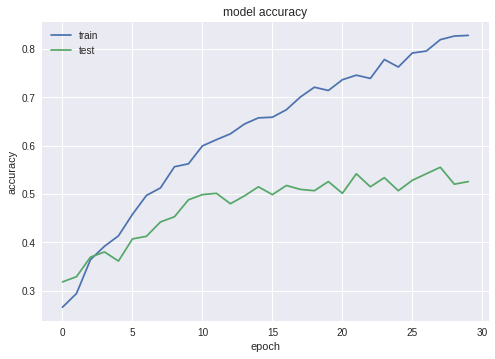

450/450 [==============================] - 1s 2ms/step
[1.2816873425907558, 0.5533333333333333]
0.5533333333333333


In [18]:
num_epochs = 30

# Create GRU model

# GRU uses less params than LSTM, for faster training
# Simple GRU model with stacked GRU layers (inspiration from NLP) - 3 layers, with dropout
# GRU layer accepts data in the form (samples, timesteps, features)

def make_GRU():
    # input is of the form: (sample, spatial, temporal)
    model = Sequential()
    model.add(Permute((2, 1), input_shape=(22, 1000)))
    
    model.add(Conv1D(filters = 64, kernel_size = 25, activation = 'elu'))
    model.add(Dropout(0.4))
    model.add(Conv1D(filters = 64, kernel_size = 25, activation = 'elu'))
    model.add(Dropout(0.4))
    
    model.add(Permute((2, 1)))
    
    # GRU layers
    model.add(GRU(32, return_sequences=True))
    model.add(GRU(32, return_sequences=True))
    
    # Dense layers
    model.add(Flatten())
    model.add(Dense(units=4, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='SGD',
                  metrics=['accuracy'])
    
    print(model.summary())
    
    return model

# make_GRU()
  
avg_acc = 0
for train_idx, test_idx in tt_splits:
    X_train = X[train_idx]
    y_train = y_cat[train_idx]
    X_test = X[test_idx]
    y_test = y_cat[test_idx]
    
    model = make_GRU()
    
    history = model.fit(X_train, y_train, validation_split=val_split, epochs=num_epochs, batch_size=batch_size)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    metrics = model.evaluate(X_test, y_test, batch_size=batch_size)
    avg_acc += metrics[1]
    print(metrics)
    break

print(avg_acc)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_23 (Permute)         (None, 1000, 22)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 976, 64)           35264     
_________________________________________________________________
dropout_23 (Dropout)         (None, 976, 64)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 952, 64)           102464    
_________________________________________________________________
dropout_24 (Dropout)         (None, 952, 64)           0         
_________________________________________________________________
permute_24 (Permute)         (None, 64, 952)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64, 32)            126080    
__________

1483/1483 [==============================] - 12s 8ms/step - loss: 1.3812 - acc: 0.2792 - val_loss: 1.3795 - val_acc: 0.2992
Epoch 3/30
1483/1483 [==============================] - 12s 8ms/step - loss: 1.3722 - acc: 0.3102 - val_loss: 1.3720 - val_acc: 0.3019
Epoch 4/30
1483/1483 [==============================] - 12s 8ms/step - loss: 1.3680 - acc: 0.3136 - val_loss: 1.3587 - val_acc: 0.3315
Epoch 5/30
1483/1483 [==============================] - 12s 8ms/step - loss: 1.3531 - acc: 0.3324 - val_loss: 1.3455 - val_acc: 0.3477
Epoch 6/30
1483/1483 [==============================] - 12s 8ms/step - loss: 1.3388 - acc: 0.3419 - val_loss: 1.3300 - val_acc: 0.3585
Epoch 7/30
 640/1483 [===========>..................] - ETA: 6s - loss: 1.3140 - acc: 0.3953

1483/1483 [==============================] - 12s 8ms/step - loss: 1.3209 - acc: 0.3655 - val_loss: 1.3188 - val_acc: 0.3585
Epoch 8/30
1483/1483 [==============================] - 12s 8ms/step - loss: 1.3089 - acc: 0.3763 - val_loss: 1.3093 - val_acc: 0.3558
Epoch 9/30
1483/1483 [==============================] - 12s 8ms/step - loss: 1.2930 - acc: 0.4100 - val_loss: 1.3020 - val_acc: 0.3774
Epoch 10/30
1483/1483 [==============================] - 12s 8ms/step - loss: 1.2727 - acc: 0.4160 - val_loss: 1.2918 - val_acc: 0.4016
Epoch 11/30
1483/1483 [==============================] - 12s 8ms/step - loss: 1.2592 - acc: 0.4370 - val_loss: 1.2825 - val_acc: 0.3989
Epoch 12/30
 672/1483 [============>.................] - ETA: 5s - loss: 1.2484 - acc: 0.4315

1483/1483 [==============================] - 12s 8ms/step - loss: 1.2415 - acc: 0.4302 - val_loss: 1.2657 - val_acc: 0.4205
Epoch 13/30
1483/1483 [==============================] - 12s 8ms/step - loss: 1.2139 - acc: 0.4788 - val_loss: 1.2481 - val_acc: 0.4286
Epoch 14/30
1483/1483 [==============================] - 12s 8ms/step - loss: 1.1766 - acc: 0.4929 - val_loss: 1.2270 - val_acc: 0.4232
Epoch 15/30
1483/1483 [==============================] - 12s 8ms/step - loss: 1.1466 - acc: 0.5064 - val_loss: 1.2726 - val_acc: 0.4016
Epoch 16/30
1483/1483 [==============================] - 12s 8ms/step - loss: 1.1197 - acc: 0.5293 - val_loss: 1.2005 - val_acc: 0.4690
Epoch 17/30
 672/1483 [============>.................] - ETA: 5s - loss: 1.0937 - acc: 0.5357

1483/1483 [==============================] - 12s 8ms/step - loss: 1.0842 - acc: 0.5475 - val_loss: 1.1883 - val_acc: 0.4879
Epoch 18/30
1483/1483 [==============================] - 12s 8ms/step - loss: 1.0606 - acc: 0.5644 - val_loss: 1.2122 - val_acc: 0.4960
Epoch 19/30
1483/1483 [==============================] - 12s 8ms/step - loss: 1.0382 - acc: 0.5475 - val_loss: 1.1968 - val_acc: 0.4987
Epoch 20/30
1483/1483 [==============================] - 12s 8ms/step - loss: 1.0110 - acc: 0.5840 - val_loss: 1.1974 - val_acc: 0.5175
Epoch 21/30
1483/1483 [==============================] - 12s 8ms/step - loss: 0.9802 - acc: 0.5920 - val_loss: 1.2055 - val_acc: 0.5202
Epoch 22/30
 672/1483 [============>.................] - ETA: 5s - loss: 0.9457 - acc: 0.6354

1483/1483 [==============================] - 12s 8ms/step - loss: 0.9529 - acc: 0.6183 - val_loss: 1.1700 - val_acc: 0.5202
Epoch 23/30
1483/1483 [==============================] - 12s 8ms/step - loss: 0.9322 - acc: 0.6217 - val_loss: 1.1709 - val_acc: 0.5499
Epoch 24/30
1483/1483 [==============================] - 12s 8ms/step - loss: 0.9112 - acc: 0.6210 - val_loss: 1.1771 - val_acc: 0.5094
Epoch 25/30
1483/1483 [==============================] - 12s 8ms/step - loss: 0.8698 - acc: 0.6480 - val_loss: 1.1687 - val_acc: 0.5310
Epoch 26/30
1483/1483 [==============================] - 12s 8ms/step - loss: 0.8359 - acc: 0.6703 - val_loss: 1.1801 - val_acc: 0.5256
Epoch 27/30
 672/1483 [============>.................] - ETA: 6s - loss: 0.8376 - acc: 0.6726

1483/1483 [==============================] - 12s 8ms/step - loss: 0.8167 - acc: 0.6804 - val_loss: 1.1818 - val_acc: 0.5337
Epoch 28/30
1483/1483 [==============================] - 12s 8ms/step - loss: 0.7832 - acc: 0.6851 - val_loss: 1.2121 - val_acc: 0.5229
Epoch 29/30
1483/1483 [==============================] - 12s 8ms/step - loss: 0.7463 - acc: 0.7148 - val_loss: 1.2537 - val_acc: 0.5337
Epoch 30/30
1483/1483 [==============================] - 12s 8ms/step - loss: 0.7230 - acc: 0.7323 - val_loss: 1.2477 - val_acc: 0.5283


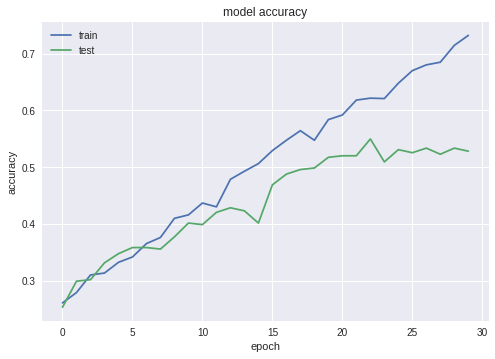

450/450 [==============================] - 1s 3ms/step
[1.3578499788708156, 0.44666666666666666]
0.44666666666666666


In [19]:
num_epochs = 30

# Create GRU model

# GRU uses less params than LSTM, for faster training
# Simple GRU model with stacked GRU layers (inspiration from NLP) - 3 layers, with dropout
# GRU layer accepts data in the form (samples, timesteps, features)

def make_LSTM():
    # input is of the form: (sample, spatial, temporal)
    model = Sequential()
    model.add(Permute((2, 1), input_shape=(22, 1000)))
    
    model.add(Conv1D(filters = 64, kernel_size = 25, activation = 'elu'))
    model.add(Dropout(0.4))
    model.add(Conv1D(filters = 64, kernel_size = 25, activation = 'elu'))
    model.add(Dropout(0.4))
    
    model.add(Permute((2, 1)))
    
    # LSTM layers
    model.add(LSTM(32, return_sequences=True))
    model.add(LSTM(32, return_sequences=True))
    
    # Dense layers
    model.add(Flatten())
    model.add(Dense(units=4, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='SGD',
                  metrics=['accuracy'])
    
    print(model.summary())
    
    return model

# make_GRU()
  
avg_acc = 0
for train_idx, test_idx in tt_splits:
    X_train = X[train_idx]
    y_train = y_cat[train_idx]
    X_test = X[test_idx]
    y_test = y_cat[test_idx]
    
    model = make_LSTM()
    
    history = model.fit(X_train, y_train, validation_split=val_split, epochs=num_epochs, batch_size=batch_size)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    metrics = model.evaluate(X_test, y_test, batch_size=batch_size)
    avg_acc += metrics[1]
    print(metrics)
    break

print(avg_acc)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_29 (Permute)         (None, 1000, 22)          0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 976, 64)           35264     
_________________________________________________________________
dropout_29 (Dropout)         (None, 976, 64)           0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 952, 64)           102464    
_________________________________________________________________
dropout_30 (Dropout)         (None, 952, 64)           0         
_________________________________________________________________
gru_46 (GRU)                 (None, 952, 128)          74112     
_________________________________________________________________
gru_47 (GRU)                 (None, 952, 128)          98688     
__________

1483/1483 [==============================] - 196s 132ms/step - loss: 1.3538 - acc: 0.3331 - val_loss: 1.2763 - val_acc: 0.3854
Epoch 2/30
1483/1483 [==============================] - 192s 130ms/step - loss: 1.1814 - acc: 0.4781 - val_loss: 1.2625 - val_acc: 0.3962
Epoch 3/30
1483/1483 [==============================] - 193s 130ms/step - loss: 1.0497 - acc: 0.5583 - val_loss: 1.4397 - val_acc: 0.3774
Epoch 4/30
1483/1483 [==============================] - 193s 130ms/step - loss: 0.9675 - acc: 0.6109 - val_loss: 1.2772 - val_acc: 0.4744
Epoch 5/30
1483/1483 [==============================] - 192s 130ms/step - loss: 0.8749 - acc: 0.6271 - val_loss: 1.5032 - val_acc: 0.4043
Epoch 6/30
 672/1483 [============>.................] - ETA: 1:37 - loss: 0.7932 - acc: 0.6815

1483/1483 [==============================] - 192s 129ms/step - loss: 0.8446 - acc: 0.6601 - val_loss: 1.3305 - val_acc: 0.4528
Epoch 7/30
1483/1483 [==============================] - 193s 130ms/step - loss: 0.7637 - acc: 0.6972 - val_loss: 1.4498 - val_acc: 0.4798
Epoch 8/30
1483/1483 [==============================] - 192s 130ms/step - loss: 0.7185 - acc: 0.7154 - val_loss: 1.4022 - val_acc: 0.5148
Epoch 9/30
1483/1483 [==============================] - 193s 130ms/step - loss: 0.6947 - acc: 0.7188 - val_loss: 1.5143 - val_acc: 0.4906
Epoch 10/30
1483/1483 [==============================] - 193s 130ms/step - loss: 0.6672 - acc: 0.7168 - val_loss: 1.6345 - val_acc: 0.4744
Epoch 11/30
 608/1483 [===========>..................] - ETA: 1:46 - loss: 0.6153 - acc: 0.7467

1483/1483 [==============================] - 193s 130ms/step - loss: 0.6135 - acc: 0.7512 - val_loss: 1.7369 - val_acc: 0.4609
Epoch 12/30
1483/1483 [==============================] - 193s 130ms/step - loss: 0.5782 - acc: 0.7856 - val_loss: 1.7353 - val_acc: 0.4528
Epoch 13/30
1483/1483 [==============================] - 193s 130ms/step - loss: 0.5350 - acc: 0.8011 - val_loss: 1.6079 - val_acc: 0.4906
Epoch 14/30
1483/1483 [==============================] - 193s 130ms/step - loss: 0.4827 - acc: 0.8179 - val_loss: 1.7783 - val_acc: 0.5121
Epoch 15/30
1483/1483 [==============================] - 193s 130ms/step - loss: 0.4762 - acc: 0.8098 - val_loss: 1.7151 - val_acc: 0.4960
Epoch 16/30
 576/1483 [==========>...................] - ETA: 1:50 - loss: 0.3617 - acc: 0.8490

1483/1483 [==============================] - 193s 130ms/step - loss: 0.4036 - acc: 0.8395 - val_loss: 2.0993 - val_acc: 0.5013
Epoch 17/30
1483/1483 [==============================] - 192s 130ms/step - loss: 0.4303 - acc: 0.8287 - val_loss: 2.1697 - val_acc: 0.4879
Epoch 18/30
1483/1483 [==============================] - 192s 129ms/step - loss: 0.4207 - acc: 0.8334 - val_loss: 2.3170 - val_acc: 0.4825
Epoch 19/30
1483/1483 [==============================] - 191s 129ms/step - loss: 0.3959 - acc: 0.8456 - val_loss: 2.2925 - val_acc: 0.5148
Epoch 20/30
1483/1483 [==============================] - 192s 129ms/step - loss: 0.3806 - acc: 0.8436 - val_loss: 2.3324 - val_acc: 0.5013
Epoch 21/30
 576/1483 [==========>...................] - ETA: 1:49 - loss: 0.3119 - acc: 0.8837

1483/1483 [==============================] - 191s 129ms/step - loss: 0.2896 - acc: 0.8874 - val_loss: 2.0771 - val_acc: 0.5499
Epoch 22/30
1483/1483 [==============================] - 192s 129ms/step - loss: 0.2756 - acc: 0.8995 - val_loss: 2.3835 - val_acc: 0.5040
Epoch 23/30
1483/1483 [==============================] - 191s 129ms/step - loss: 0.2968 - acc: 0.8955 - val_loss: 2.3026 - val_acc: 0.4798
Epoch 24/30
1483/1483 [==============================] - 191s 129ms/step - loss: 0.2436 - acc: 0.9036 - val_loss: 3.5504 - val_acc: 0.4313
Epoch 25/30
1483/1483 [==============================] - 192s 129ms/step - loss: 0.2973 - acc: 0.8989 - val_loss: 2.4834 - val_acc: 0.5121
Epoch 26/30
 576/1483 [==========>...................] - ETA: 1:49 - loss: 0.2315 - acc: 0.9115

1483/1483 [==============================] - 192s 129ms/step - loss: 0.2448 - acc: 0.9056 - val_loss: 2.6770 - val_acc: 0.5094
Epoch 27/30
1483/1483 [==============================] - 192s 129ms/step - loss: 0.2543 - acc: 0.9002 - val_loss: 2.8514 - val_acc: 0.5040
Epoch 28/30
1483/1483 [==============================] - 192s 130ms/step - loss: 0.2705 - acc: 0.9029 - val_loss: 2.6544 - val_acc: 0.5094
Epoch 29/30
1483/1483 [==============================] - 192s 129ms/step - loss: 0.1900 - acc: 0.9265 - val_loss: 2.6859 - val_acc: 0.5067
Epoch 30/30
1483/1483 [==============================] - 193s 130ms/step - loss: 0.1895 - acc: 0.9332 - val_loss: 4.1503 - val_acc: 0.4205


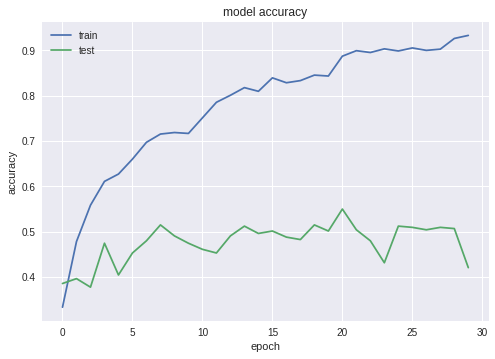

450/450 [==============================] - 12s 27ms/step
[4.150140681796604, 0.4177777777777778]
0.4177777777777778


In [21]:
num_epochs = 30

# Create GRU model

# GRU uses less params than LSTM, for faster training
# Simple GRU model with stacked GRU layers (inspiration from NLP) - 3 layers, with dropout
# GRU layer accepts data in the form (samples, timesteps, features)

def make_GRU():
    # input is of the form: (sample, spatial, temporal)
    model = Sequential()
    model.add(Permute((2, 1), input_shape=(22, 1000)))
    
    model.add(Conv1D(filters = 64, kernel_size = 25, activation = 'elu'))
    model.add(Dropout(0.4))
    model.add(Conv1D(filters = 64, kernel_size = 25, activation = 'elu'))
    model.add(Dropout(0.4))
    
    # GRU layers
    model.add(GRU(128, return_sequences=True))
    model.add(GRU(128, return_sequences=True))
    model.add(GRU(64, return_sequences=True))
    
    model.add(Conv1D(filters = 64, kernel_size = 25, activation = 'elu'))
    model.add(Dropout(0.4))
    model.add(Conv1D(filters = 64, kernel_size = 25, activation = 'elu'))
    model.add(Dropout(0.4))
    
    model.add(Permute((2, 1)))
    
    # Dense layers
    model.add(Flatten())
    model.add(Dense(units=4, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='SGD',
                  metrics=['accuracy'])
    
    print(model.summary())
    
    return model

# make_GRU()
  
avg_acc = 0
for train_idx, test_idx in tt_splits:
    X_train = X[train_idx]
    y_train = y_cat[train_idx]
    X_test = X[test_idx]
    y_test = y_cat[test_idx]
    
    model = make_GRU()
    
    history = model.fit(X_train, y_train, validation_split=val_split, epochs=num_epochs, batch_size=batch_size)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    metrics = model.evaluate(X_test, y_test, batch_size=batch_size)
    avg_acc += metrics[1]
    print(metrics)
    break

print(avg_acc)